Bibliotecas externas ao código

In [1]:
import sys
import os
import csv
import yaml

import math
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import butter, filtfilt
import statistics as st
import matplotlib.pyplot as plt


## Parâmetros

In [2]:
data_path = "DataSet"
yaml_keys = ("Null", "gender", "age", "weight", "height", "walkingAid")

header_file = (
                'Sample', 'Gender', 'Age', 'Mass', 'Height', 'Walking Aids', \
                'Total Time Left Limb', 'Steps Left Limb', 'Mean Stepping Time Left Limb', 'Mean Speed Left Limb', 'Mean Force Left Limb', 'Distance Left Limb', 'Mean Power Left Limb', \
                'Total Time Right Limb','Steps Right Limb', 'Mean Stepping Time Right Limb', 'Mean Speed Right Limb', 'Mean Force Right Limb', 'Distance Right Limb', 'Mean Power Right Limb', \
                'Mean Inclination Left Limb', 'Mean Inclination Right Limb', \
                'MainDirXX Left Limb', 'MainDirYY Left Limb', 'MainDirZZ Left Limb', \
                'MainDirXX Right Limb', 'MainDirYY Right Limb', 'MainDirZZ Right Limb', \
                'Sleeping Time/h', 'DisCode', 'DisName', 
            )
number_samples = 90

output_file_name = "results_withFilters_Overview.csv"
error_file_name = "ilegible_withFilters_Overview.csv"
gravity_acceleration = 9.806
Dict_Diseases = {}

This dataset captures detailed lower limb movement data during a 10-meter walk test, which is useful for gait and mobility analysis. The data is collected using two tilebox sensors, strategically positioned to capture a comprehensive set of motion parameters.

Each sensor records the following types of data:

Accelerometer Data: Measures linear acceleration, providing insights into the speed and direction of leg movements.
Gyroscope Data: Captures angular velocity, aiding in the analysis of limb rotation and stability during walking.
Magnetometer Data: Records magnetic field data, useful for determining the orientation and heading of the sensors relative to the Earth's magnetic field.
Temperature Data: Monitors ambient or sensor temperature, which can impact sensor performance or provide environmental context.

The dataset also includes a YAML file containing demographic and lifestyle information for each participant, which provides critical context for data interpretation. The YAML file details include:

Demographic Information: Gender, age, weight, height.
Physical Activity: Frequency, duration, and type of exercise (e.g., walking).
Diet and Nutrition: Dietary habits, portions of fruits or vegetables consumed, daily water intake.
Health Status: Presence of health pathologies (e.g., motor-related issues), smoking status, and current physical state.
Sleep and Energy Levels: Average hours of sleep and perceived energy levels.
Motivation and Participation: Interest in participating in the study.
Mobility Aids: Use of walking aids, if applicable.

file:
Demographic Information:
    gender: Female
    age: 69
    weight: 70
    height: 158
Physical Activity:
    physicalExercise: "2 or 3 times per week"
    amountOfTime: "Between 1 and 2 hours"
    exerciseType: Walk
Diet and Nutrition:
    diet: false
    dietType: 
    portionsOfFruitsOrVegetables: "1 or 2"
    amountOfWaterPerDay: "Between 1L and 2L"
Health Status:
    healthPathology: true
    pathologyType:
      - Motor
    smoker: false
Sleep and Energy Levels:
    hoursOfSleep: 8
    currentPhysicalState: "With a lot of energy"
Motivation and Participation:
    interestInParticipation: 4
Mobility Aids:
    walkingAid: false
    walkingAidName: 


## Internal Functions


### User Mathematical Functions

In [3]:
def vect_length(vector):
    """
        Length of an euclidean vector of 2 and 3 dimensions
        Input:
            vector is an list 
    """

    return math.sqrt(sum([math.pow(component, 2) for component in vector]))

def orientation(vector):
    """
        Unit vector of an euclidean vector of 2 and 3 dimensions
        Input:
            vector is an list
    """

    vector_len = vect_length(vector)

    return [component/vector_len for component in vector]

def Euler(dt, dx):
    """
        Euler's method:
            First Order Differentional Equation Resolution
            Stating nul vector as initial condition
        Input:
            dt - non-fix time steps list
            dx - x derivative in order of t
    """

    xx = [[0.0, 0.0, 0.0]]

    for ii in range(1,len(dt)):
        xx = xx + [[xx[-1][0] + dt[ii] * dx[ii - 1][0], \
                  xx[-1][1] + dt[ii] * dx[ii - 1][1], \
                  xx[-1][2] + dt[ii] * dx[ii - 1][2]]]

    return xx

def Esc_Prod(list01, list02):
    """
        Escalar Product between two euclidean vectors of 2 and 3 dimensions
        Input:
            list01 is an list of a list
            list02 is an list of a list
    """

    return [sum([comp01*comp02 for comp01,comp02 in zip(vect01,vect02)]) for vect01,vect02 in zip(list01, list02)]

def RoundFloat(List):
    
    for ii in range(len(List)):
        if isinstance(List[ii], float):
            List[ii] = float(f'{(List[ii] + 0.0005):.4f}')
        elif isinstance(List[ii], list):
            list01 = [float(f'{(element + 0.0005):.4f}') for element in List[ii] if isinstance(List[ii], float)]
            if len(list01) > 0:
                List[ii] = list01
            
    return List


### Application Functions

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def accelerometer(exp_data):
    ### Accelerometer

    Acelerometer_data = exp_data['accelerometer']

    Meter_Time = [data[0] for data in Acelerometer_data]
    Exp_Acceleration = [data[1] for data in Acelerometer_data]
    
    # Time variables
    Experiment_Tt_Time = (Meter_Time[-1] - Meter_Time[0]) * 1.0e-3
    Experiment_Time = [(Meter_Time[ii] - Meter_Time[0]) * 1e-3 for ii in range(len(Meter_Time))]
    Time_Interv = [0.0] + [(Meter_Time[ii] - Meter_Time[ii - 1]) * 1e-3 for ii in range(1, len(Meter_Time))]

    # Unit conversion: Apply gravity to convert to meters per second squared
    Converted_Accel = [[element * gravity_acceleration * 0.001 for element in line] for line in Exp_Acceleration]

    Orient_ot_acceleration = [orientation(line) for line in Converted_Accel]

    Corrected_Accel = []
    for component, grav_comp in zip(Converted_Accel, Orient_ot_acceleration):
        Corrected_Accel = Corrected_Accel + [[line1 - gravity_acceleration * line2 for line1, line2 in zip(component, grav_comp)]]

    # Apply Butterworth low-pass filter to smooth the corrected acceleration data
    cutoff = 3
    fs = 1 / Time_Interv[1]  # Sampling frequency, derived from time interval

    Corrected_Accel_flt = [butter_lowpass_filter([accel[i] for accel in Corrected_Accel], cutoff, fs) for i in range(3)]

    # Rebuild Corrected_Accel with the filtered data
    Corrected_Accel = [[Corrected_Accel_flt[0][i], Corrected_Accel_flt[1][i], Corrected_Accel_flt[2][i]] for i in range(len(Corrected_Accel_flt[0]))]

    # Acceleration plot (Filtered)
    fig00, axs00 = plt.subplots(4, figsize=(16, 32), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
    Accel_flt = []  # Initialize Accel_flt to store filtered acceleration data
    
    for cmp in range(0, 3):
        Accel_comp = []
        for cmp_cg, cmp_sg in zip(Converted_Accel, Corrected_Accel):
            Accel_comp = Accel_comp + [[cmp_cg[cmp], cmp_sg[cmp]]]
        axs00[cmp].plot(Experiment_Time, Accel_comp)
        
        New_Experiment_Time = []  # Reset New_Experiment_Time for each axis
        Accel_cmp_flt = []  # Reset Accel_cmp_flt for each axis
        lrg = 5  # Group size for filtering
        
        for tt in range(0, (len(Experiment_Time) // lrg)):
            New_Experiment_Time.append(Experiment_Time[tt * lrg])
            
            ssss = []
            for pos in range(0, lrg):
                if tt * lrg + pos < len(Accel_comp):
                    ssss.append(Accel_comp[tt * lrg + pos][1])
            Accel_cmp_flt.append(st.median(ssss))  # Use the median of the group
        
        if cmp == 0:
            Accel_flt = [[elem01] for elem01 in Accel_cmp_flt]
        else:
            Accel_flt = [elem01 + [elem02] for elem01, elem02 in zip(Accel_flt, Accel_cmp_flt)]
        
        axs00[cmp].plot(New_Experiment_Time, Accel_cmp_flt)                
        axs00[cmp].legend(['Cmp_cg', 'Cmp_sg', 'Cmp_sg_flt'])

    # Check if Accel_flt has values before plotting
    if len(Accel_flt) > 0:
        axs00[3].plot(Experiment_Time, [vect_length(line) for line in Corrected_Accel])
        axs00[3].plot(New_Experiment_Time, [vect_length(line) for line in Accel_flt])
    else:
        print("Warning: Accel_flt is empty, skipping plot.")

    plt.show()

    # Velocity
    Velocity = [[0.0, 0.0, 0.0]]  # Initial velocity

    for i in range(1, len(Corrected_Accel)):
        dt = (Meter_Time[i] - Meter_Time[i-1]) * 1.0e-3  # Convert ms to seconds
        new_velocity = [
            Corrected_Accel[i-1][0] * dt,
            Corrected_Accel[i-1][1] * dt,
            Corrected_Accel[i-1][2] * dt
        ]

        Velocity.append(new_velocity)

    # Position
    Position = Euler(Time_Interv, Velocity)

    # Calculate step-related data
    Corrected_Accel_Int = [vect_length(line) for line in Corrected_Accel]

    Peeks_Loc = [Time_ind for Time_ind in range(1, len(Corrected_Accel_Int) - 1)
                 if (((Corrected_Accel_Int[Time_ind] - Corrected_Accel_Int[Time_ind - 1]) > 0) &
                     ((Corrected_Accel_Int[Time_ind + 1] - Corrected_Accel_Int[Time_ind]) < 0) &
                     (Corrected_Accel_Int[Time_ind] > (st.fmean(Corrected_Accel_Int) + st.stdev(Corrected_Accel_Int) / 3)))]

    Num_Steps = len(Peeks_Loc)

    # # Compute Mean and STD of Step Time
    # try:
    #     Mean_Step_Time = st.fmean([(Meter_Time[Peeks_Loc[ii]] - Meter_Time[Peeks_Loc[ii - 1]]) * 1.0e-3 for ii in range(1, Num_Steps)])
    #     STD_Step_Time = st.stdev([(Meter_Time[Peeks_Loc[ii]] - Meter_Time[Peeks_Loc[ii - 1]]) * 1.0e-3 for ii in range(1, Num_Steps)], Mean_Step_Time)
    # except st.StatisticsError:
    #     Mean_Step_Time = "#N/A"
    #     STD_Step_Time = "#N/A"

    # Plot filtered acceleration and step locations
    fig, axs = plt.subplots(2, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [1, 1]})
    axs[0].plot(Experiment_Time, Corrected_Accel_Int)
    axs[0].scatter([Experiment_Time[j] for j in Peeks_Loc], [Corrected_Accel_Int[j] for j in Peeks_Loc])

    try:
        Mean_Step_Time = st.fmean([((Meter_Time[Peeks_Loc[ii]] - Meter_Time[Peeks_Loc[ii-1]])*1.0e-3) for ii in range(1, Num_Steps)])
        STD_Step_Time = st.stdev([((Meter_Time[Peeks_Loc[ii]] - Meter_Time[Peeks_Loc[ii-1]])*1.0e-3) for ii in range(1, Num_Steps)], Mean_Step_Time)
        step = 1; lower_limit = Peeks_Loc[0]
        while ((lower_limit - step) >= 0) & (Experiment_Time[lower_limit] - Experiment_Time[lower_limit - step] < Mean_Step_Time/2):
            Peeks_Loc = [Peeks_Loc[0] - 1] + Peeks_Loc
            step = step +1
        step = 1; higher_limit = Peeks_Loc[-1]
        while ((higher_limit + step) < (len(Experiment_Time) - 1)) & ((Experiment_Time[higher_limit + step] - Experiment_Time[higher_limit]) < Mean_Step_Time/2):
            Peeks_Loc = Peeks_Loc + [Peeks_Loc[-1] + 1]
            step = step +1
        Study_Interval = [Meter_Time[Peeks_Loc[0]], Meter_Time[Peeks_Loc[-1]]]
    except st.StatisticsError:
        return [Experiment_Tt_Time, Num_Steps, '#N/A', '#N/A', '#N/A', '#N/A', '#N/A', '#N/A', ['#N/A', '#N/A']]
    
    axs[0].scatter([Experiment_Time[j] for j in [Peeks_Loc[0], Peeks_Loc[-1]]], [Corrected_Accel_Int[j] for j in [Peeks_Loc[0], Peeks_Loc[-1]]], cmap='red')
    axs[0].set_title("Filtered Acceleration with Steps")

    # Speed (Filtered)
    Speed = [vect_length(line) for line in Velocity[Peeks_Loc[0]:Peeks_Loc[-1] + 1]]

    axs[1].plot(Experiment_Time[Peeks_Loc[0]:Peeks_Loc[-1] + 1], Speed)
    axs[1].set_title("Speed (Filtered)")

    plt.show()

    # fig, axs = plt.subplots(1, 1, figsize=(16, 8))

    # # Acceleration (Non-Filtered)
    # Acceleration_Non_Filtered = [vect_length(line) for line in Non_Filtered_Acceleration]
    # axs.plot(Experiment_Time, Acceleration_Non_Filtered, label="Non-Filtered Acceleration", color="orange")
    # axs.set_title("Non-Filtered Acceleration")
    # axs.legend()

    # plt.show()

    Mean_Acceleration = st.mean(Speed)
    Mean_Speed = st.mean(Speed)

    Displacement = [[0.0, 0.0, 0.0]]
    for ii in range(1, len(Position)):
        Displacement = Displacement + [[Position[ii][0] - Position[ii - 1][0], 
                                        Position[ii][1] - Position[ii - 1][1], 
                                        Position[ii][2] - Position[ii - 1][2]]]
    Distance = [vect_length(line) for line in Displacement[Peeks_Loc[0]:Peeks_Loc[-1] + 1]]

    Experiment_Tt_Time = (Meter_Time[Peeks_Loc[-1]] - Meter_Time[Peeks_Loc[0]]) * 1.0e-3
    Mean_Power = st.fsum(Esc_Prod(Corrected_Accel[Peeks_Loc[0]:Peeks_Loc[-1] + 1], Velocity[Peeks_Loc[0]:Peeks_Loc[-1] + 1]))

    return RoundFloat([Experiment_Tt_Time, Num_Steps, Mean_Step_Time, STD_Step_Time, Mean_Acceleration, Mean_Speed, st.fsum(Distance), Mean_Power, Study_Interval])

def gyroscope(data, std_interval):
    ### Gyroscope
    Gyro_data = data['gyroscope']

    try:
        # Extract meter time and angular velocity, handling the structure properly
        Meter_Time = [entry[0][0] for entry in Gyro_data]  # Extract only the timestamp (first value of the tuple)
        AngVel = [[entry[0][1], entry[0][2], entry[0][3]] for entry in Gyro_data]  # Extract angular velocities

        # Ensure Meter_Time and AngVel have valid data
        if len(Meter_Time) < 2 or len(AngVel) < 2:
            print("Invalid gyroscope data format. Skipping sample.")
            return ['#N/A']

        # Time variables    
        Experiment_Tt_Time = (Meter_Time[-1] - Meter_Time[0]) * 1.0e-3

        Experiment_Time = [(Meter_Time[ii] - Meter_Time[0]) * 1e-3 for ii in range(len(Meter_Time))]
        Time_Interv = [0.0] + [(Meter_Time[ii] - Meter_Time[ii - 1]) * 1e-3 for ii in range(1, len(Meter_Time))]

        # Rotating Angle
        Ang = Euler(Time_Interv, AngVel)

        Meter_Time = [Instant for Instant in Meter_Time if ((Instant - Meter_Time[0]) * 1.0e-3) > 10.0]
        First_Ten_Sec = len(AngVel) - len(Meter_Time)
        AngVel[:First_Ten_Sec] = []
        Ang[:First_Ten_Sec] = []

        # Extract study interval period
        low_limit = 0
        high_limit = len(Meter_Time) - 1
        time_inst_index = 0
        while time_inst_index < (len(Meter_Time) / 2 + 1):
            if Meter_Time[low_limit] < std_interval[0]:
                low_limit += 1
            if Meter_Time[high_limit] > std_interval[1]:
                high_limit -= 1
            time_inst_index += 1

        Meter_Time = Meter_Time[low_limit: high_limit + 1]
        Experiment_Tt_Time = (Meter_Time[-1] - Meter_Time[0]) * 1.0e-3
        Experiment_Time = [(Meter_Time[ii] - Meter_Time[0]) * 1e-3 for ii in range(len(Meter_Time))]

        AngVel = AngVel[low_limit: high_limit + 1]
        Ang = Ang[low_limit: high_limit + 1]        

        AngVel_dir_n = [orientation(line) for line in AngVel]

        Mean_Ang = [
            st.fmean([Ang[ii][0] for ii in range(len(Ang))]), 
            st.fmean([Ang[ii][1] for ii in range(len(Ang))]), 
            st.fmean([Ang[ii][2] for ii in range(len(Ang))])
        ]
        
        return RoundFloat([vect_length(Ang[-1])])

    except (st.StatisticsError, IndexError, TypeError) as e:
        print(f"Error processing gyroscope data: {e}")
        return ['#N/A']
        
def magnetometer(data, std_interval):
    ### Magnetometer
    MagF_data = data['magnetometer']

    try:
        # Extract meter time and magnetic field values, handling the structure properly
        Meter_Time = [entry[0][0] for entry in MagF_data]  # Extract only the timestamp (first value of the tuple)
        MagFld = [[entry[0][1], entry[0][2], entry[0][3]] for entry in MagF_data]  # Extract magnetic field components

        # Time variables    
        Experiment_Tt_Time = (Meter_Time[-1] - Meter_Time[0]) * 1.0e-3
        Experiment_Time = [(Meter_Time[ii] - Meter_Time[0]) * 1e-3 for ii in range(len(Meter_Time))]
        Time_Interv = [0.0] + [(Meter_Time[ii] - Meter_Time[ii - 1]) * 1e-3 for ii in range(1, len(Meter_Time))]

        # Extract the study interval period
        low_limit = 0
        high_limit = len(Meter_Time) - 1
        time_inst_index = 0
        while time_inst_index <= (len(Meter_Time) / 2 + 1):
            if Meter_Time[low_limit] < std_interval[0]:
                low_limit += 1
            if Meter_Time[high_limit] > std_interval[1]:
                high_limit -= 1
            time_inst_index += 1
        
        Meter_Time = Meter_Time[low_limit: high_limit + 1]
        Experiment_Tt_Time = (Meter_Time[-1] - Meter_Time[0]) * 1.0e-3
        Experiment_Time = [(Meter_Time[ii] - Meter_Time[0]) * 1e-3 for ii in range(len(Meter_Time))]
        
        MagFld = MagFld[low_limit: high_limit + 1]
        
        # Apply Butterworth low-pass filter to smooth the magnetic field data
        cutoff = 3
        fs = 1 / Experiment_Time[1]  # Sampling frequency, derived from time interval
        print("MagFld: ", MagFld)

        MagFld_flt = [butter_lowpass_filter([mag[i] for mag in MagFld], cutoff, fs) for i in range(3)]

        # Combine the filtered components back into a list of lists
        MagFld_filtered = [[float(MagFld_flt[0][i]), float(MagFld_flt[1][i]), float(MagFld_flt[2][i])] for i in range(len(MagFld_flt[0]))]
        
        MagFld_dir_n = [orientation(line) for line in MagFld_filtered]
        
        print("MagFld_dir_n: ", MagFld_dir_n)
        
        Mean_MagFld =[st.fmean([(MagFld_dir_n[ii][0]-MagFld_dir_n[0][0]) for ii in range(1,len(MagFld_dir_n))]), \
                      st.fmean([(MagFld_dir_n[ii][1]-MagFld_dir_n[0][1]) for ii in range(1,len(MagFld_dir_n))]), \
                      st.fmean([(MagFld_dir_n[ii][2]-MagFld_dir_n[0][2]) for ii in range(1,len(MagFld_dir_n))])]
        

        return [Mean_MagFld, MagFld_dir_n]
        # return RoundFloat([MagFld_dir_n[-1][0]-MagFld_dir_n[0][0], MagFld_dir_n[-1][1]-MagFld_dir_n[0][1], MagFld_dir_n[-1][2]-MagFld_dir_n[0][2]])

    except (st.StatisticsError, IndexError, TypeError) as e:
        print(f"Error processing magnetometer data: {e}")
        return ['#N/A', '#N/A', '#N/A']



## Main function

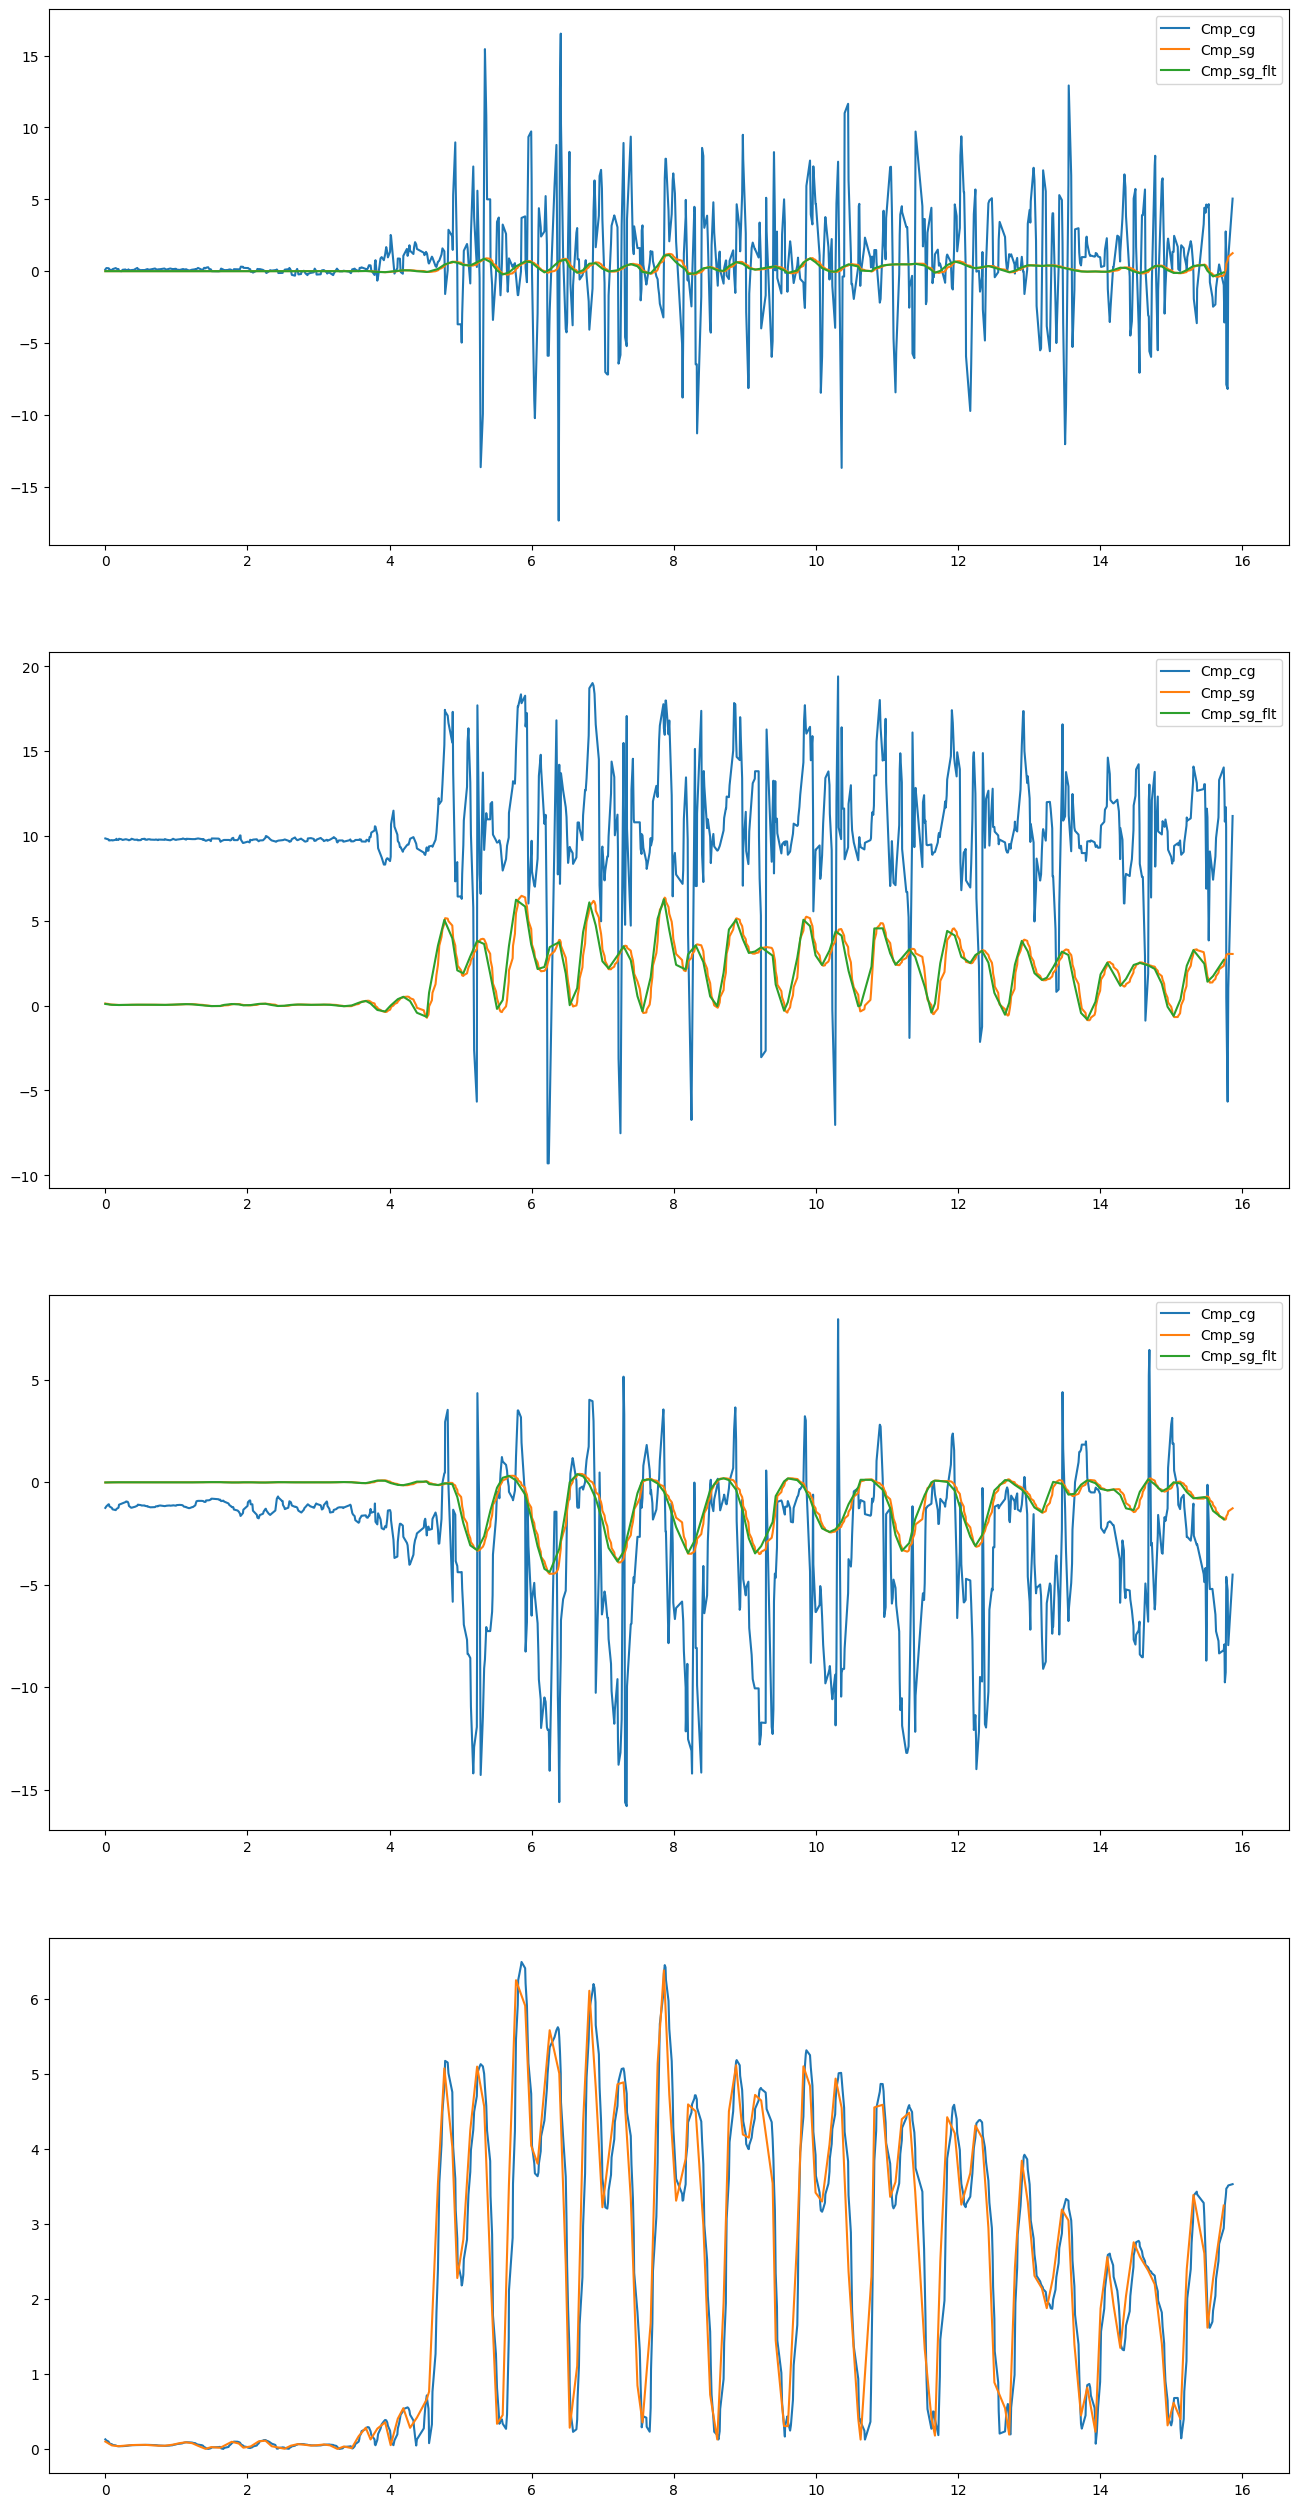

/tmp/ipykernel_2511/3480396486.py:133: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter([Experiment_Time[j] for j in [Peeks_Loc[0], Peeks_Loc[-1]]], [Corrected_Accel_Int[j] for j in [Peeks_Loc[0], Peeks_Loc[-1]]], cmap='red')


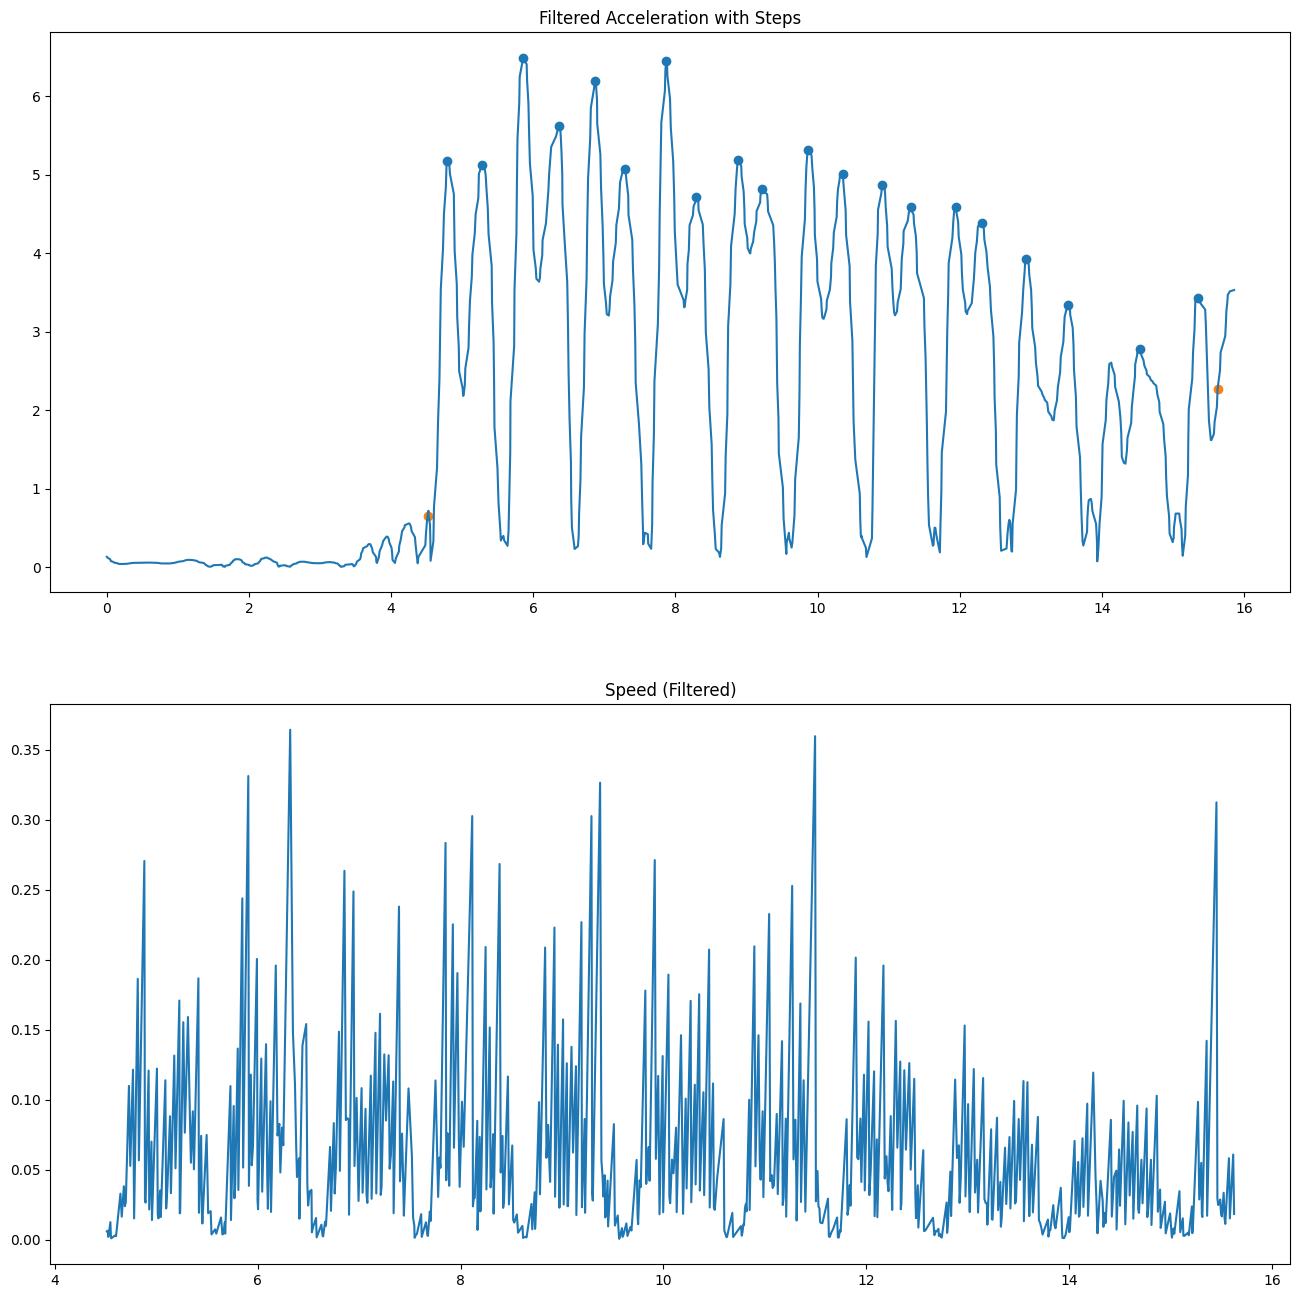

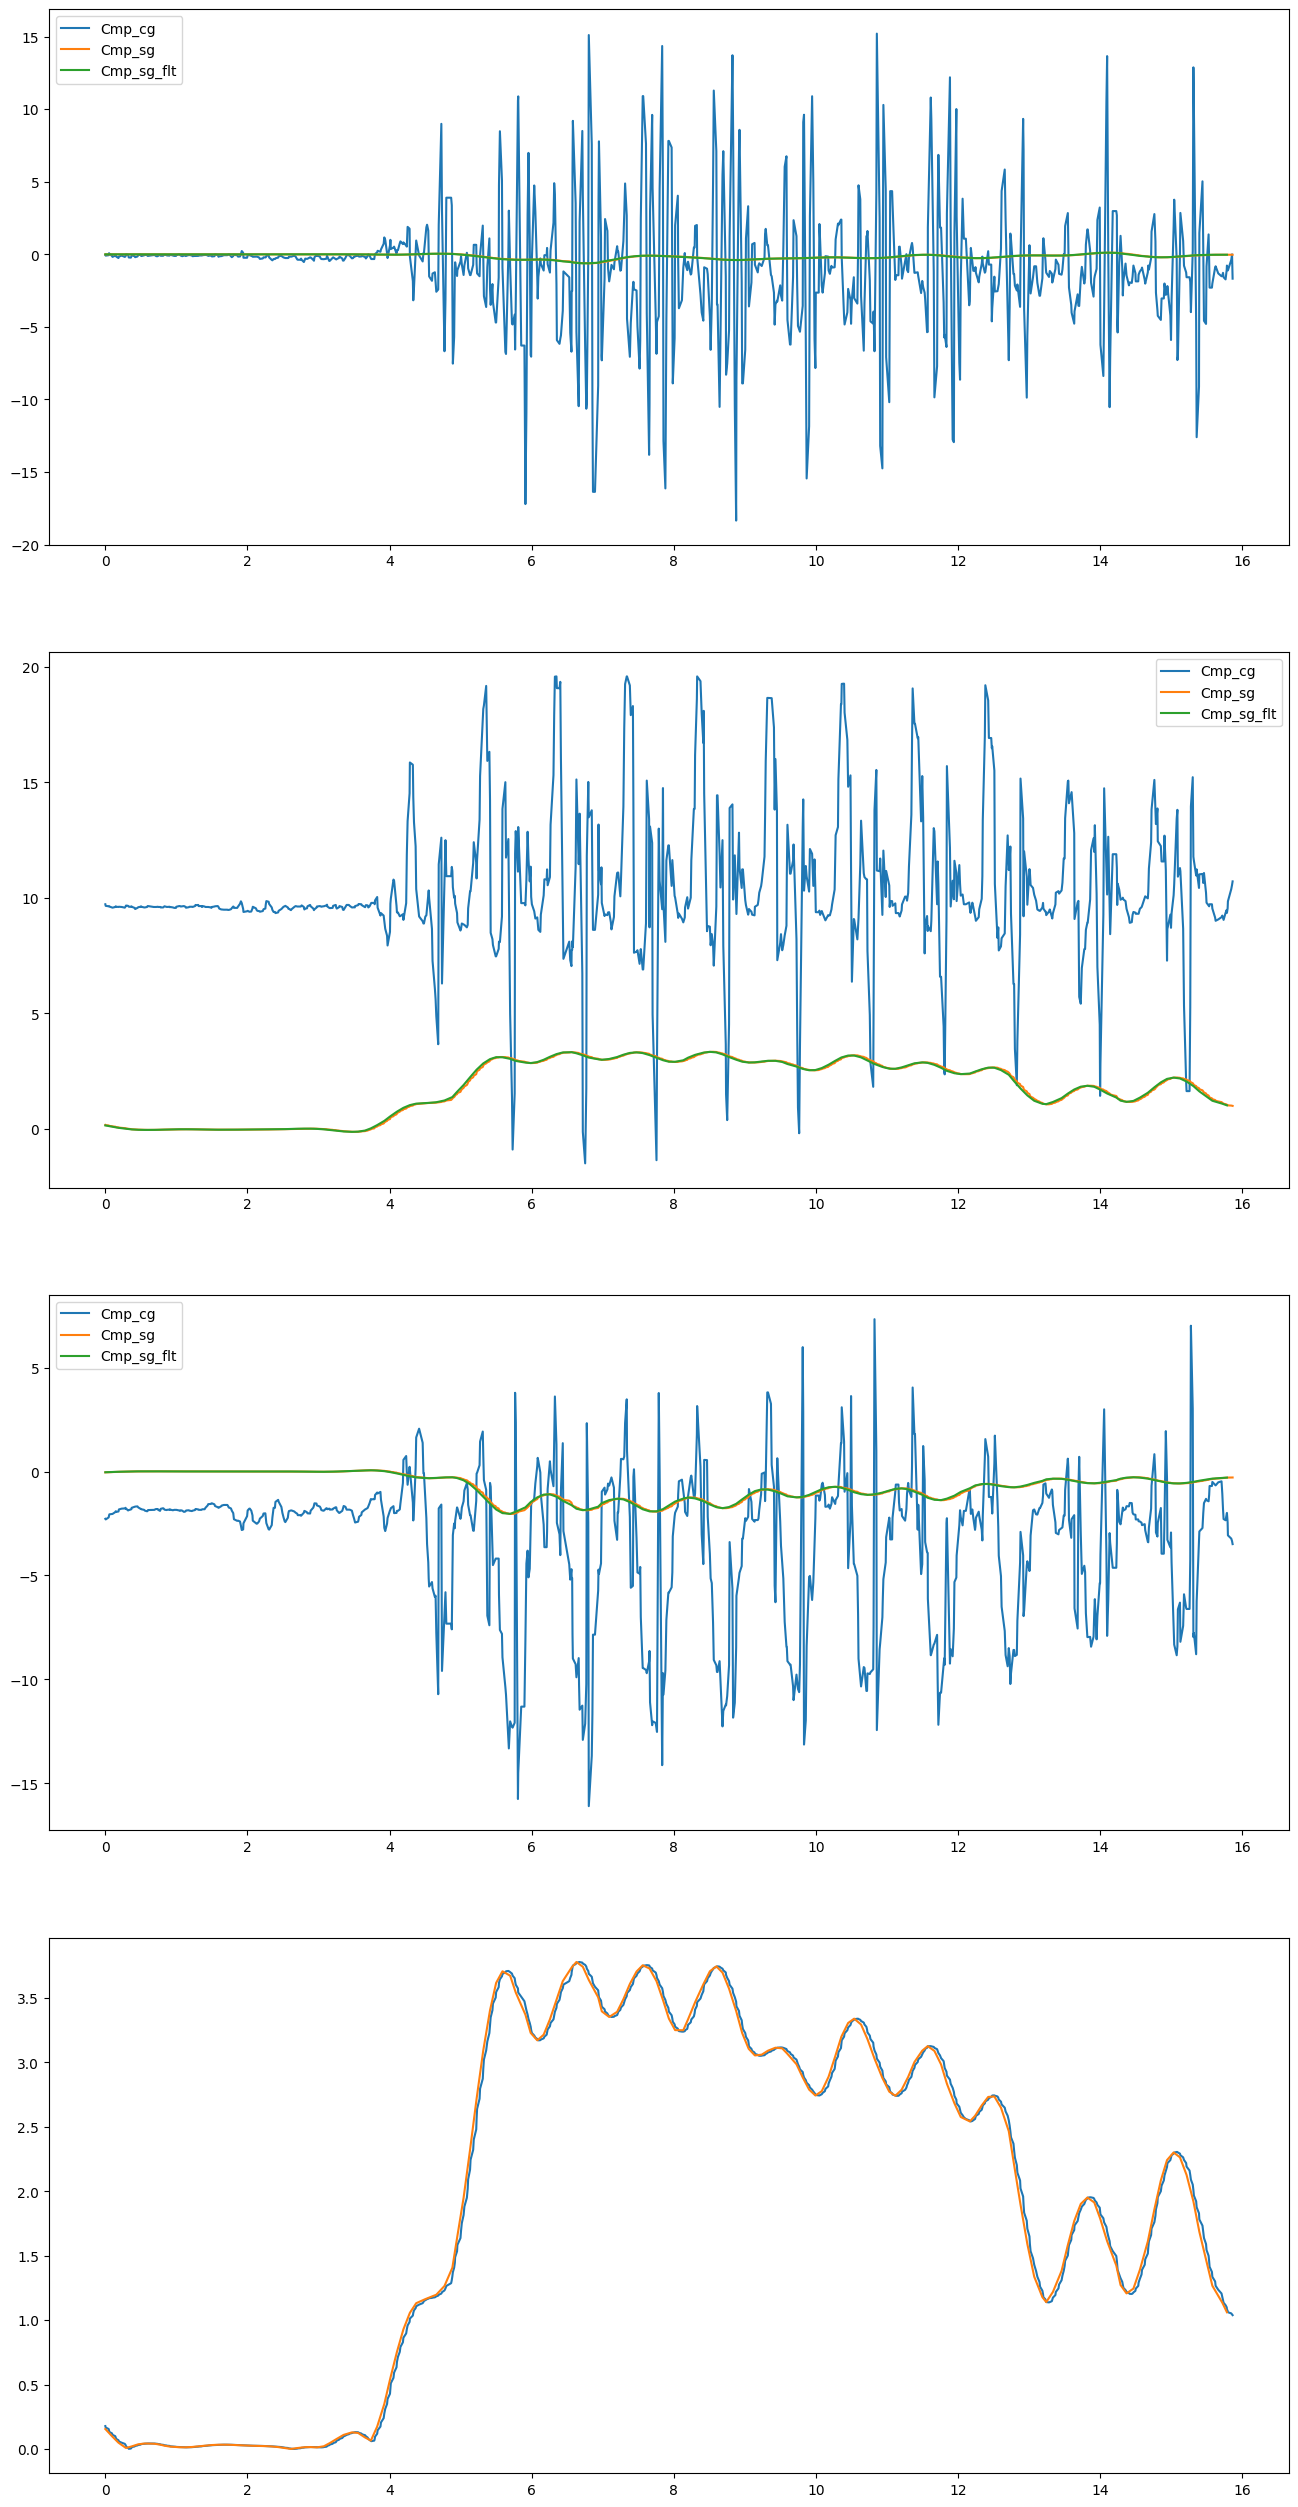

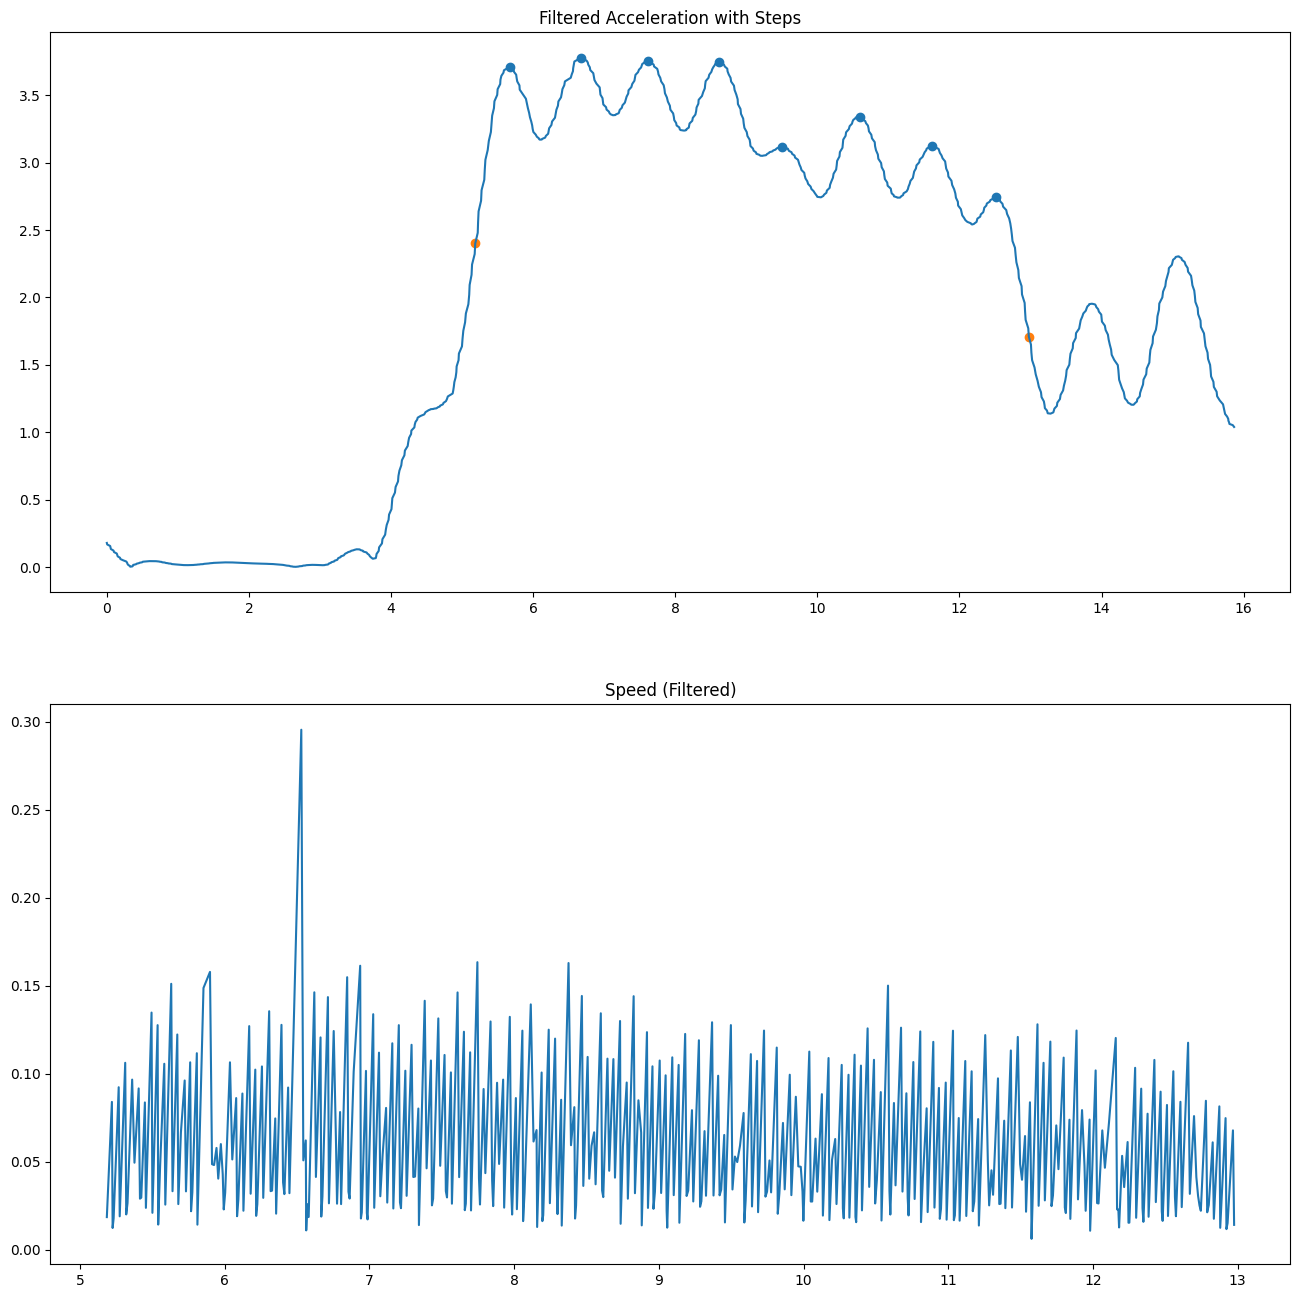

MagFld:  [[-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-52.0, 391.0, -238.0], [-36.0, 399.0, -243.0], [-39.0, 376.0, -250.0], [-51.0, 394.0, -237.0], [-43.0, 397.0, -249.0], [-43.0, 397.0, -249.0], [-43.0, 397.0, -249.0], [-43.0, 397.0, -249.0], [-43.0, 397.0, -249.0], [-43.0, 397.0, -249.0], [-43.0, 397.0, -249.0], [-43.0, 382.0, -247.0], [-36.0, 391.0, -244.0], [-51.0, 381.0, -246.0], [-36.0, 379.0, -252.0], [-24.0, 382.0, -240.0], [-22.0, 381.0, -244.0], [-45.0, 399.0, -243.0], [-27.0, 382.0, -231.0], [-27.0, 397.0, -262.0], [-34.0, 381.0, -259.0], [-57.0, 382.0, -250.0], [-21.0, 387.0, -249.0], [-43.0, 372.0, -255.0], [-37.0, 387.0, -247.0], [-19.0, 379.0, -255.0], [-16.0, 402.0, -258.0], [-25.0, 403.0, -243.0], [-36.0, 408.0, -238.0], [-28.0, 384.0, -252.0], [-27.0

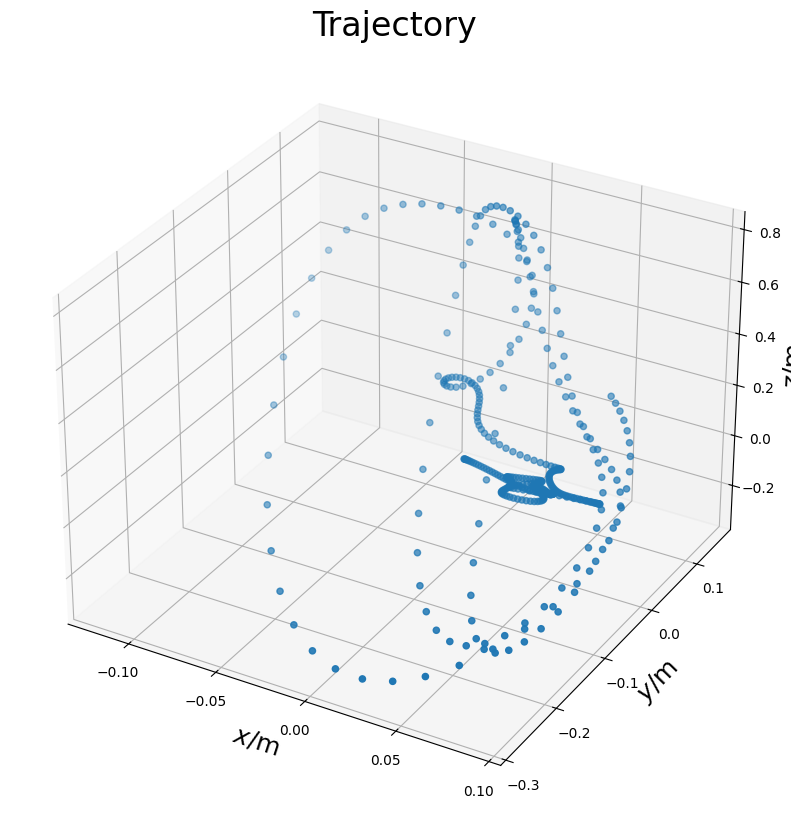

MagFld:  [[174.0, 441.0, -121.0], [184.0, 435.0, -109.0], [187.0, 441.0, -102.0], [187.0, 447.0, -91.0], [183.0, 442.0, -87.0], [193.0, 438.0, -127.0], [180.0, 417.0, -121.0], [183.0, 438.0, -114.0], [186.0, 426.0, -114.0], [192.0, 426.0, -117.0], [195.0, 439.0, -94.0], [169.0, 427.0, -111.0], [184.0, 426.0, -120.0], [189.0, 432.0, -103.0], [190.0, 424.0, -117.0], [195.0, 432.0, -124.0], [184.0, 430.0, -132.0], [205.0, 438.0, -121.0], [184.0, 426.0, -117.0], [183.0, 432.0, -123.0], [193.0, 439.0, -106.0], [193.0, 439.0, -100.0], [184.0, 453.0, -123.0], [175.0, 447.0, -118.0], [183.0, 423.0, -111.0], [169.0, 435.0, -109.0], [184.0, 433.0, -108.0], [175.0, 448.0, -103.0], [171.0, 439.0, -112.0], [190.0, 433.0, -114.0], [174.0, 427.0, -121.0], [199.0, 442.0, -139.0], [187.0, 442.0, -120.0], [181.0, 436.0, -102.0], [192.0, 432.0, -97.0], [195.0, 435.0, -105.0], [177.0, 435.0, -130.0], [174.0, 441.0, -112.0], [175.0, 432.0, -114.0], [187.0, 427.0, -115.0], [189.0, 426.0, -115.0], [177.0, 43

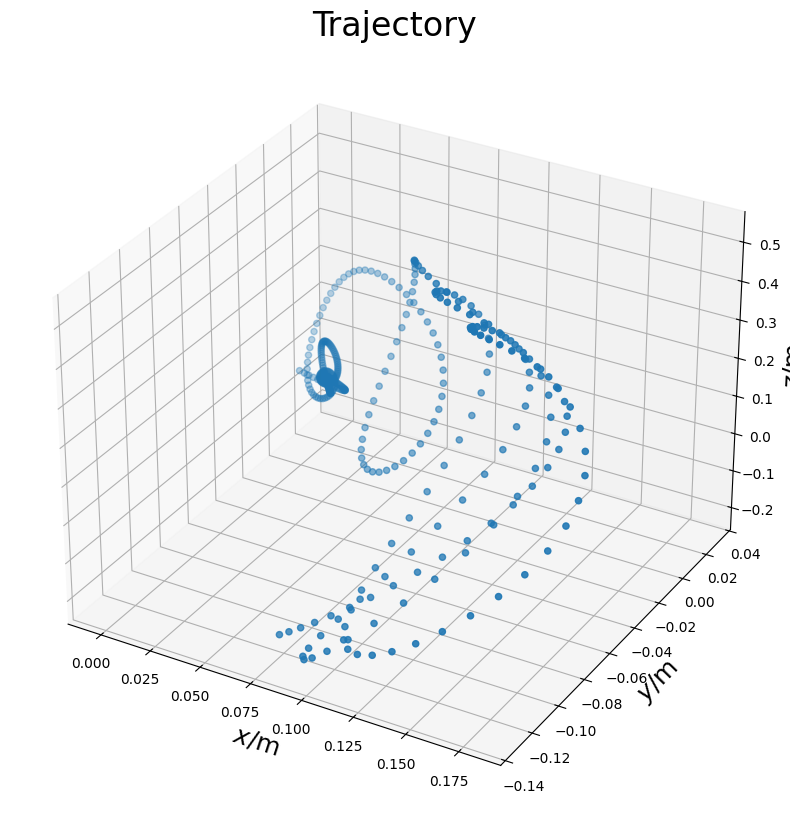

In [5]:
with open(output_file_name, 'w', newline='', encoding='utf-8') as output_file, \
     open(error_file_name, 'w', newline='', encoding='utf-8') as error_file:
    
    writer = csv.writer(output_file)
    dump = csv.writer(error_file)
    
    writer.writerow(header_file)
    dump.writerow(header_file)

    # Only the second participant is being analyzed
    for diretoria in range(1, 2):
    # for diretoria in range(1, number_samples + 1):
        # Iterate over the directories (participants)
        sample_path = data_path + '/' + str(diretoria)

        if os.path.isdir(sample_path):

            file_list = os.listdir(sample_path)

            # Handle YAML file
            yaml_file = sample_path + '/' + [file for file in file_list if '.yml' in file][0]

            record_row = ()

            with open(yaml_file, 'r') as f:
                info_data = yaml.safe_load(f)
                record_row = record_row + (str(diretoria),)
                for name in range(1, 6):
                    record_row = record_row + (info_data[yaml_keys[name]],)
            
            data_values={}
            Study_Interval = None

            # Handle multiple accelerometer files
            accel_files = [file for file in file_list if 'Accelerometer' in file]

            for accel_file in accel_files:
                accel_file_path = sample_path + '/' + accel_file

                with open(accel_file_path, 'r') as f:
                    accel_data = f.readlines()

                    data_values['accelerometer'] = []
                    for time_instant in accel_data[1:]:
                        time_instant = time_instant.split(sep=',')
                        data_values['accelerometer'] = \
                            data_values['accelerometer'] + \
                            [[eval(time_instant[0]), [eval(component) for component in time_instant[1:]]]]

                    # Accelerometer analysis
                    AccelResults = [[diretoria] + accelerometer(data_values)]

                if not(isinstance(AccelResults[0][3], str)):
                    record_row = record_row + (AccelResults[0][1], \
                                               AccelResults[0][2], \
                                               AccelResults[0][3], \
                                               info_data['weight'] * AccelResults[0][5], \
                                               AccelResults[0][6], \
                                               AccelResults[0][7], \
                                               RoundFloat([info_data['weight']*AccelResults[0][8]])[0], )
                else:
                    record_row = record_row + (AccelResults[0][1], \
                                               AccelResults[0][2], \
                                               '#N/A', '#N/A', '#N/A', '#N/A', '#N/A', )

                Study_Interval = AccelResults[-1]

            # Handle multiple gyroscope files
            gyro_files = [file for file in file_list if 'Gyroscope' in file]

            for gyro_file in gyro_files:
                gyro_file_path = sample_path + '/' + gyro_file

                with open(gyro_file_path, 'r') as f:
                    gyro_data = f.readlines()

                    data_values['gyroscope'] = []
                    for time_instant in gyro_data[1:]:
                        time_instant = time_instant.split()
                        data_values['gyroscope'] = \
                            data_values['gyroscope'] + \
                            [[eval(time_instant[0]), [eval(component) for component in time_instant[1:]]]]

                    # Gyroscope analysis
                    GyroResults = [[diretoria] + gyroscope(data_values, Study_Interval)]

                record_row = record_row + (GyroResults[0][1], )

            # Handle multiple magnetometer files
            mag_files = [file for file in file_list if 'Magnetometer' in file]

            for mag_file in mag_files:
                mag_file_path = sample_path + '/' + mag_file

                with open(mag_file_path, 'r') as f:
                    mag_data = f.readlines()

                    data_values['magnetometer'] = []
                    for time_instant in mag_data[1:]:
                        time_instant = time_instant.split()
                        data_values['magnetometer'] = \
                            data_values['magnetometer'] + \
                            [[eval(time_instant[0]), [eval(component) for component in time_instant[1:]]]]

                    # Magnetometer analysis
                    mag = magnetometer(data_values, Study_Interval)
                    MagResults = [[diretoria] + mag[0]]

                record_row = record_row + (MagResults[0][1], MagResults[0][2], MagResults[0][3],)
                
                # Extract the numerical values, ignoring the first element (directory number)
                extracted_values = mag[1]

                fig = plt.figure(figsize=(10, 10))
                ax = fig.add_subplot(111, projection='3d')

                # Now you can use flattened_values for plotting
                x_values = [value[0] - extracted_values[0][0] for value in extracted_values]
                y_values = [value[1] - extracted_values[0][1] for value in extracted_values]
                z_values = [value[2] - extracted_values[0][2] for value in extracted_values]

                ax.scatter(x_values, y_values, z_values)
                ax.set_xlabel('$x / \\text{m}$', fontsize="18")
                ax.set_ylabel('$y / \\text{m}$', fontsize="18")
                ax.set_zlabel('$z / \\text{m}$', fontsize="18")
                ax.set_title('Trajectory', size='24', color='k')
                plt.show()

            record_row = record_row + tuple([info_data["hoursOfSleep"]])

            # Handle pathologyType
            if info_data.get("pathologyType") and len(info_data["pathologyType"]) > 0:
                disease_codes = []
                disease_names = []
                List_Diseases = [disease.title() for disease in info_data["pathologyType"]]
                for disease in List_Diseases:
                    if disease not in Dict_Diseases:
                        if not Dict_Diseases:
                            Codice = 100
                        Dict_Diseases[disease] = Codice + 1
                        Codice += 1
                    disease_codes.append(str(Dict_Diseases[disease]))
                    disease_names.append(disease)

                combined_codes = ";".join(disease_codes)
                combined_names = ";".join(disease_names)

                writer.writerow(record_row + (combined_codes, combined_names))

            else:
                print(f"No pathologyType found for record {diretoria}.")
                writer.writerow(record_row + ("#N/A", "#N/A"))

        else:
            print("End of the routine")

    

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn

In [7]:
results_csv = os.path.join('results.csv')
df_gender = pd.read_csv(results_csv, encoding='utf-8')
df_gender.drop('Sample', inplace=True, axis=1)
df_gender.drop('DisCode', inplace=True, axis=1)
df_gender.drop('DisName', inplace=True, axis=1)

In [8]:
df_gender

,Gender,Age,Mass,Height,Walking Aids,Total Time Left Limb,Steps Left Limb,Mean Stepping Time Left Limb,Mean Speed Left Limb,Mean Force Left Limb,...,Mean Power Right Limb,Mean Inclination Left Limb,Mean Inclination Right Limb,MainDirXX Left Limb,MainDirYY Left Limb,MainDirZZ Left Limb,MainDirXX Right Limb,MainDirYY Right Limb,MainDirZZ Right Limb,Sleeping Time/h
0,Female,69,70,158,False,11.1165,20,0.5571,3.8850,0.0555,...,5583.9985,150.9938,109.9483,0.027480,0.009883,0.073350,0.058851,-0.024351,0.091176,8
1,Male,83,52,160,False,14.3905,25,0.5842,1.6484,0.0317,...,4347.1277,35.7100,80.0778,0.032316,0.026949,0.112462,0.052759,0.005341,0.194007,4
2,Male,83,52,160,False,12.8245,16,0.8048,1.7784,0.0342,...,7596.6805,124.1530,47.3380,0.016301,-0.249532,0.682728,0.484037,-0.280600,0.159972,4
3,Female,87,68,160,False,13.4465,22,0.6138,3.4340,0.0505,...,7922.9933,150.7970,149.0922,0.006636,0.009041,0.086545,0.141388,-0.059778,0.110049,9
4,Female,87,68,160,False,12.5225,11,1.1421,3.6448,0.0536,...,8732.1049,153.6423,159.6263,-0.032187,-0.186978,0.093479,0.101641,-0.018037,-0.038366,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Female,88,70,155,False,16.4715,14,1.1776,1.9950,0.0285,...,3783.1575,131.3768,65.5799,0.020167,-0.204601,0.140387,0.198537,-0.140888,0.050090,9
86,Female,84,75,155,False,13.3305,14,0.9636,4.6950,0.0626,...,17224.9655,72.8033,70.7319,-0.059000,0.073105,0.178794,-0.013945,0.021601,0.093981,6
87,Female,84,75,155,False,14.0185,41,0.3440,5.1525,0.0687,...,9156.5030,92.4739,71.5123,-0.078729,-0.176215,0.070800,0.378084,-0.156460,0.023335,6
88,Female,87,74,155,False,10.0865,15,0.6733,4.5140,0.0610,...,18667.6697,89.3420,45.5701,0.050349,0.064318,0.196777,0.048814,-0.056257,0.086366,8


In [9]:
train, test = train_test_split(df_gender, test_size=0.2, random_state=42)

X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

#Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Classifier comparison

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings


........ Score and Classification Report for Nearest Neighbors .............

              precision    recall  f1-score   support

      Female       0.75      1.00      0.86        12
        Male       1.00      0.33      0.50         6

    accuracy                           0.78        18
   macro avg       0.88      0.67      0.68        18
weighted avg       0.83      0.78      0.74        18



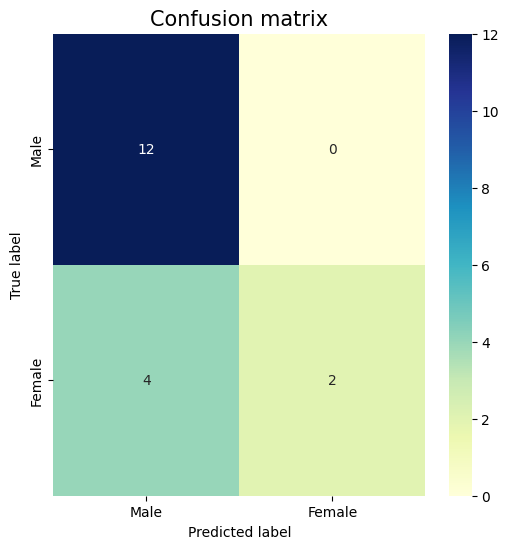


........ Score and Classification Report for Linear SVM .............

              precision    recall  f1-score   support

      Female       0.67      1.00      0.80        12
        Male       0.00      0.00      0.00         6

    accuracy                           0.67        18
   macro avg       0.33      0.50      0.40        18
weighted avg       0.44      0.67      0.53        18



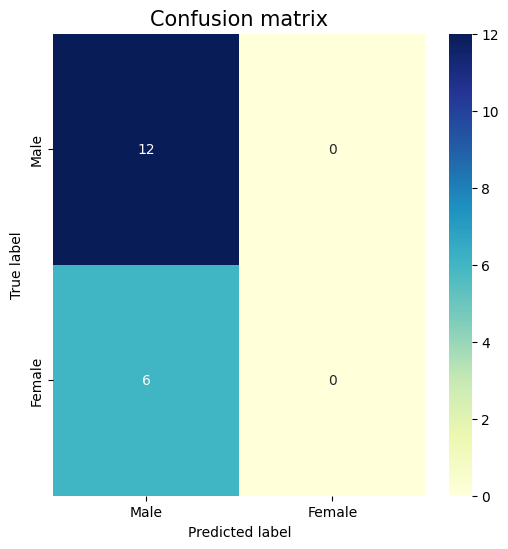


........ Score and Classification Report for RBF SVM .............

              precision    recall  f1-score   support

      Female       0.67      1.00      0.80        12
        Male       0.00      0.00      0.00         6

    accuracy                           0.67        18
   macro avg       0.33      0.50      0.40        18
weighted avg       0.44      0.67      0.53        18



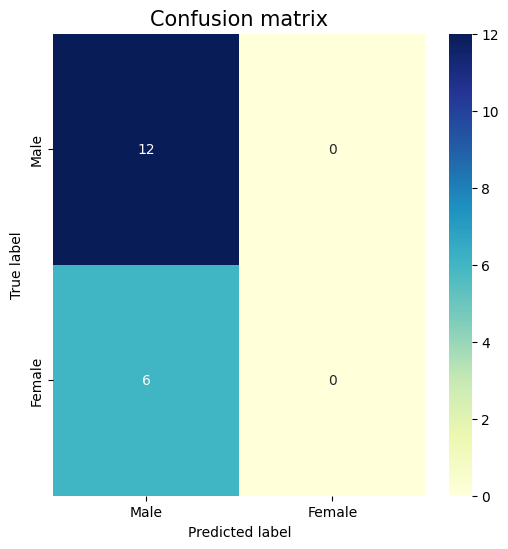


........ Score and Classification Report for Decision Tree .............

              precision    recall  f1-score   support

      Female       0.91      0.83      0.87        12
        Male       0.71      0.83      0.77         6

    accuracy                           0.83        18
   macro avg       0.81      0.83      0.82        18
weighted avg       0.84      0.83      0.84        18



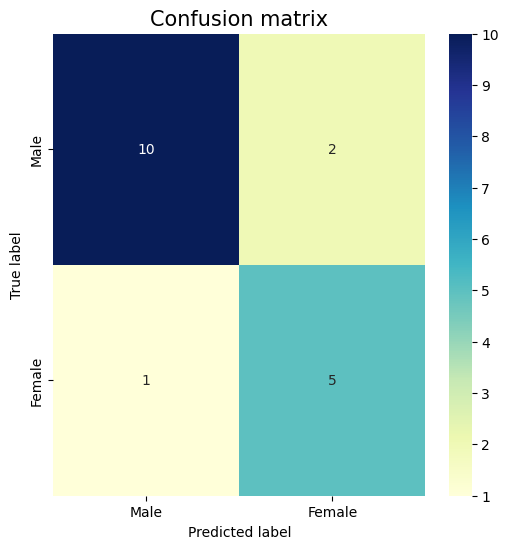


........ Score and Classification Report for Random Forest .............

              precision    recall  f1-score   support

      Female       0.75      1.00      0.86        12
        Male       1.00      0.33      0.50         6

    accuracy                           0.78        18
   macro avg       0.88      0.67      0.68        18
weighted avg       0.83      0.78      0.74        18



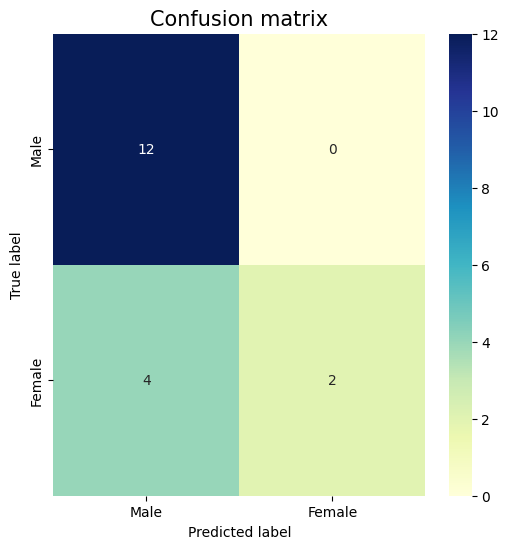


........ Score and Classification Report for Neural Net .............

              precision    recall  f1-score   support

      Female       0.92      0.92      0.92        12
        Male       0.83      0.83      0.83         6

    accuracy                           0.89        18
   macro avg       0.88      0.88      0.88        18
weighted avg       0.89      0.89      0.89        18



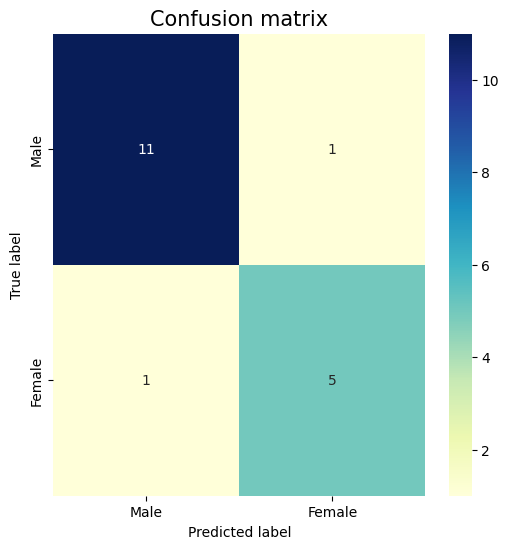


........ Score and Classification Report for AdaBoost .............

              precision    recall  f1-score   support

      Female       0.92      0.92      0.92        12
        Male       0.83      0.83      0.83         6

    accuracy                           0.89        18
   macro avg       0.88      0.88      0.88        18
weighted avg       0.89      0.89      0.89        18



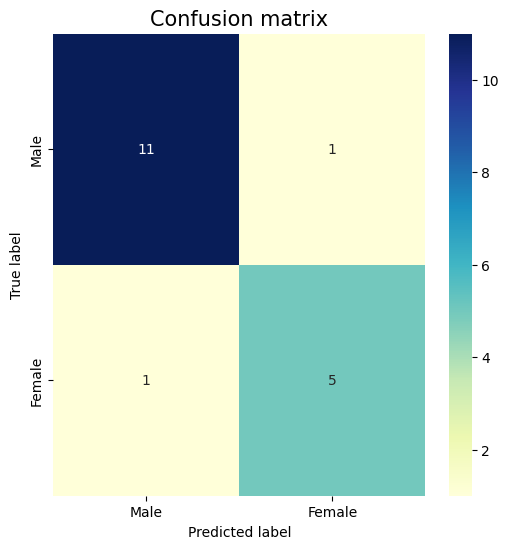


........ Score and Classification Report for Naive Bayes .............

              precision    recall  f1-score   support

      Female       0.92      0.92      0.92        12
        Male       0.83      0.83      0.83         6

    accuracy                           0.89        18
   macro avg       0.88      0.88      0.88        18
weighted avg       0.89      0.89      0.89        18



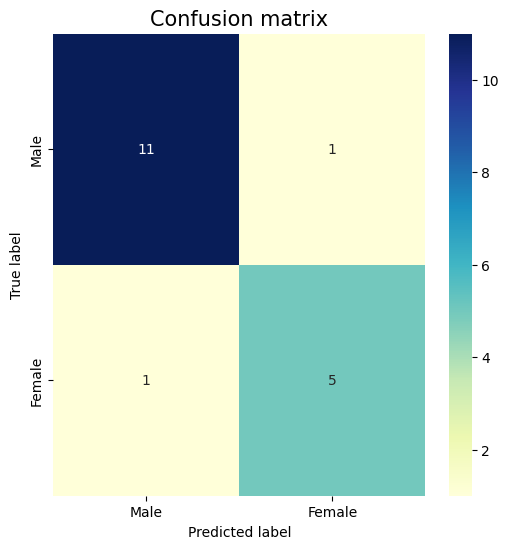

|       Classifier        |          Score          |
------------------------------------------------------
|    Nearest Neighbors    |   0.7777777777777778    |
|       Linear SVM        |   0.6666666666666666    |
|         RBF SVM         |   0.6666666666666666    |
|      Decision Tree      |   0.8333333333333334    |
|      Random Forest      |   0.7777777777777778    |
|       Neural Net        |   0.8888888888888888    |
|        AdaBoost         |   0.8888888888888888    |
|       Naive Bayes       |   0.8888888888888888    |


In [11]:
warnings.filterwarnings('ignore')

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
]
alllabels = ['Male', 'Female']
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print('\n........ Score and Classification Report for {0} .............\n'.format(name))
    scores.append(score)
    print(classification_report(y_test, y_pred))

    cfm1 = confusion_matrix(y_test, y_pred)
    fig= plt.subplots(figsize=(6,6))
    seaborn.heatmap(cfm1, annot=True, xticklabels=alllabels, yticklabels=alllabels,cmap = 'YlGnBu')
    plt.title('Confusion matrix', fontsize = 15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
print("|{0:^25}|{1:^25}|".format("Classifier","Score"))
print("------------------------------------------------------")
for name,score in zip(names,scores):
    print("|{0:^25}|{1:^25}|".format(name,score))

# Classification By Disease

In [12]:
df_dis = pd.read_csv(results_csv, encoding='utf-8')
df_dis.drop(['Sample', 'Gender', 'DisCode'], inplace=True, axis=1)

col_list = list(df_dis.columns)
col_list[0], col_list[-1] = col_list[-1], col_list[0]
df_dis = df_dis[col_list]

df_dis = df_dis.drop_duplicates().reset_index(drop=True)

df_dis.head()

,DisName,Mass,Height,Walking Aids,Total Time Left Limb,Steps Left Limb,Mean Stepping Time Left Limb,Mean Speed Left Limb,Mean Force Left Limb,Distance Left Limb,...,Mean Inclination Left Limb,Mean Inclination Right Limb,MainDirXX Left Limb,MainDirYY Left Limb,MainDirZZ Left Limb,MainDirXX Right Limb,MainDirYY Right Limb,MainDirZZ Right Limb,Sleeping Time/h,Age
0,Motor,70,158,False,11.1165,20,0.5571,3.8850,0.0555,0.4555,...,150.9938,109.9483,0.027480,0.009883,0.073350,0.058851,-0.024351,0.091176,8,69
1,Neurologic,52,160,False,14.3905,25,0.5842,1.6484,0.0317,0.3373,...,35.7100,80.0778,0.032316,0.026949,0.112462,0.052759,0.005341,0.194007,4,83
2,Neurologic,52,160,False,12.8245,16,0.8048,1.7784,0.0342,0.3299,...,124.1530,47.3380,0.016301,-0.249532,0.682728,0.484037,-0.280600,0.159972,4,83
3,Vestibular,68,160,False,13.4465,22,0.6138,3.4340,0.0505,0.4946,...,150.7970,149.0922,0.006636,0.009041,0.086545,0.141388,-0.059778,0.110049,9,87
4,Vestibular,68,160,False,12.5225,11,1.1421,3.6448,0.0536,0.4962,...,153.6423,159.6263,-0.032187,-0.186978,0.093479,0.101641,-0.018037,-0.038366,9,87


In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

In [14]:
df_disease = pd.read_csv(results_csv, encoding='utf-8')
df_disease.drop(['Gender', 'DisCode'], inplace=True, axis=1)

# Split the 'DisName' column by ';' and create one row for each disease
df_disease['DisName'] = df_disease['DisName'].str.split(';')
df_disease_expanded = df_disease.explode('DisName')

# Clean the 'DisName' column
df_disease_expanded['DisName'] = df_disease_expanded['DisName'].str.strip()
df_disease_expanded['DisName'] = df_disease_expanded['DisName'].fillna('No Disease')

# Features (exclude 'DisName')
X = df_disease_expanded.drop(columns=['DisName'])
# Labels
y = df_disease_expanded['DisName']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Classifier Comparison


........ Score and Classification Report for Nearest Neighbors .............

                               precision    recall  f1-score   support

                        Motor       0.33      0.40      0.36         5
                   Neurologic       0.00      0.00      0.00         2
                   Vestibular       0.00      0.00      0.00        10
                   No Disease       0.00      0.00      0.00         4
                    Metabolic       0.00      0.00      0.00         1
Orthopedic Or Physical Trauma       0.00      0.00      0.00         4
                     Muscular       0.00      0.00      0.00         0

                     accuracy                           0.08        26
                    macro avg       0.05      0.06      0.05        26
                 weighted avg       0.06      0.08      0.07        26



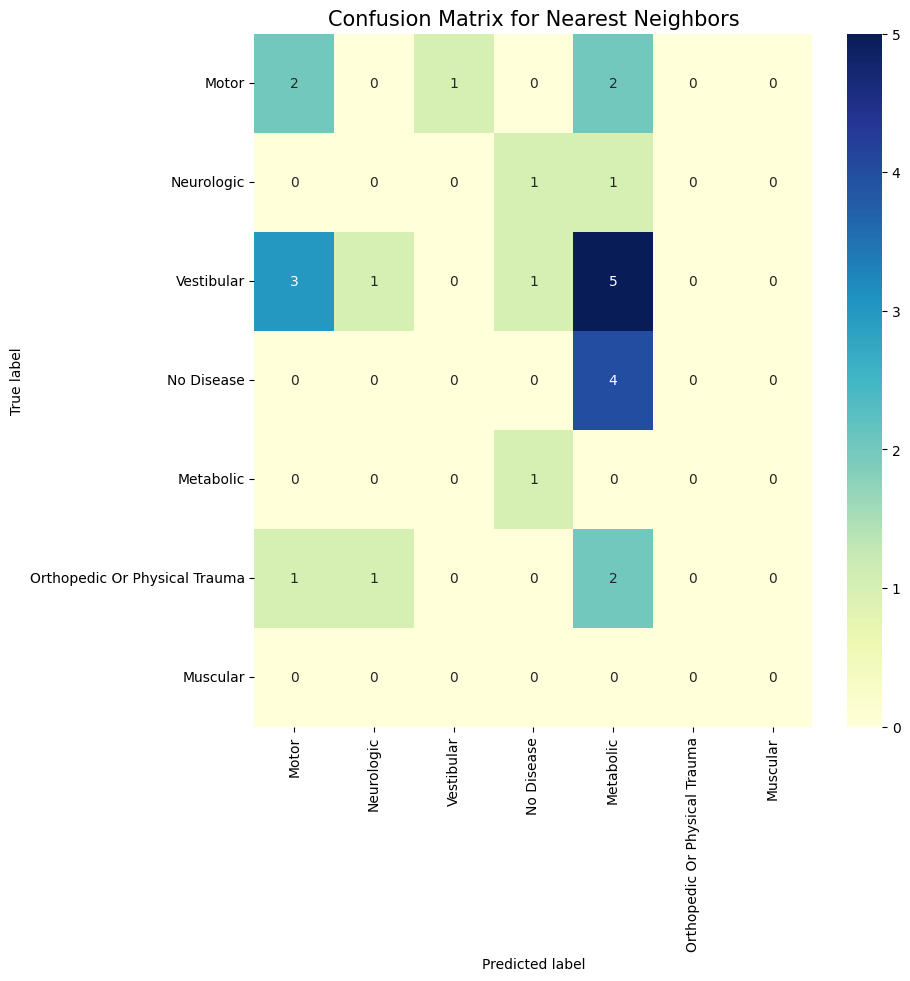


........ Score and Classification Report for Linear SVM .............

                               precision    recall  f1-score   support

                        Motor       0.25      0.20      0.22         5
                   Neurologic       0.00      0.00      0.00         2
                   Vestibular       0.25      0.20      0.22        10
                   No Disease       0.50      0.25      0.33         4
                    Metabolic       0.00      0.00      0.00         1
Orthopedic Or Physical Trauma       0.00      0.00      0.00         4
                     Muscular       0.00      0.00      0.00         0

                     accuracy                           0.15        26
                    macro avg       0.14      0.09      0.11        26
                 weighted avg       0.22      0.15      0.18        26



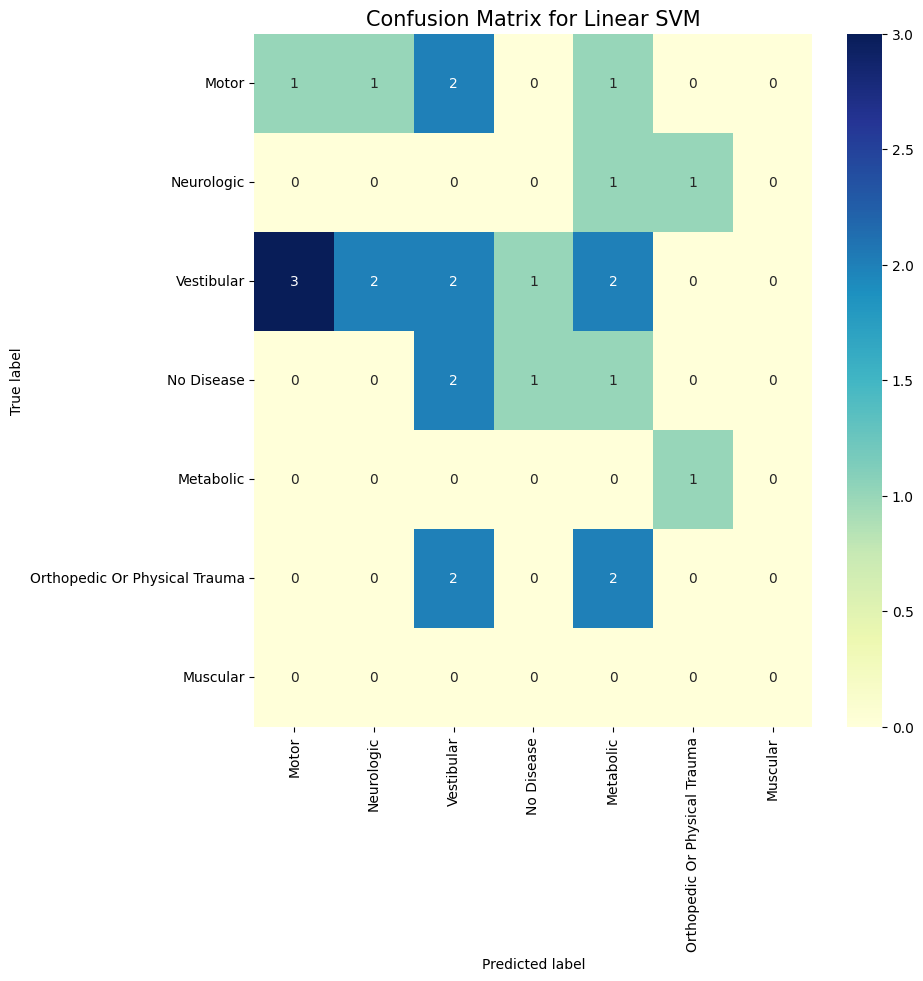


........ Score and Classification Report for RBF SVM .............

                               precision    recall  f1-score   support

                        Motor       0.00      0.00      0.00       5.0
                   Neurologic       0.00      0.00      0.00       2.0
                   Vestibular       0.00      0.00      0.00      10.0
                   No Disease       0.00      0.00      0.00       4.0
                    Metabolic       0.00      0.00      0.00       1.0
Orthopedic Or Physical Trauma       0.00      0.00      0.00       4.0
                     Muscular       0.00      0.00      0.00       0.0

                     accuracy                           0.00      26.0
                    macro avg       0.00      0.00      0.00      26.0
                 weighted avg       0.00      0.00      0.00      26.0



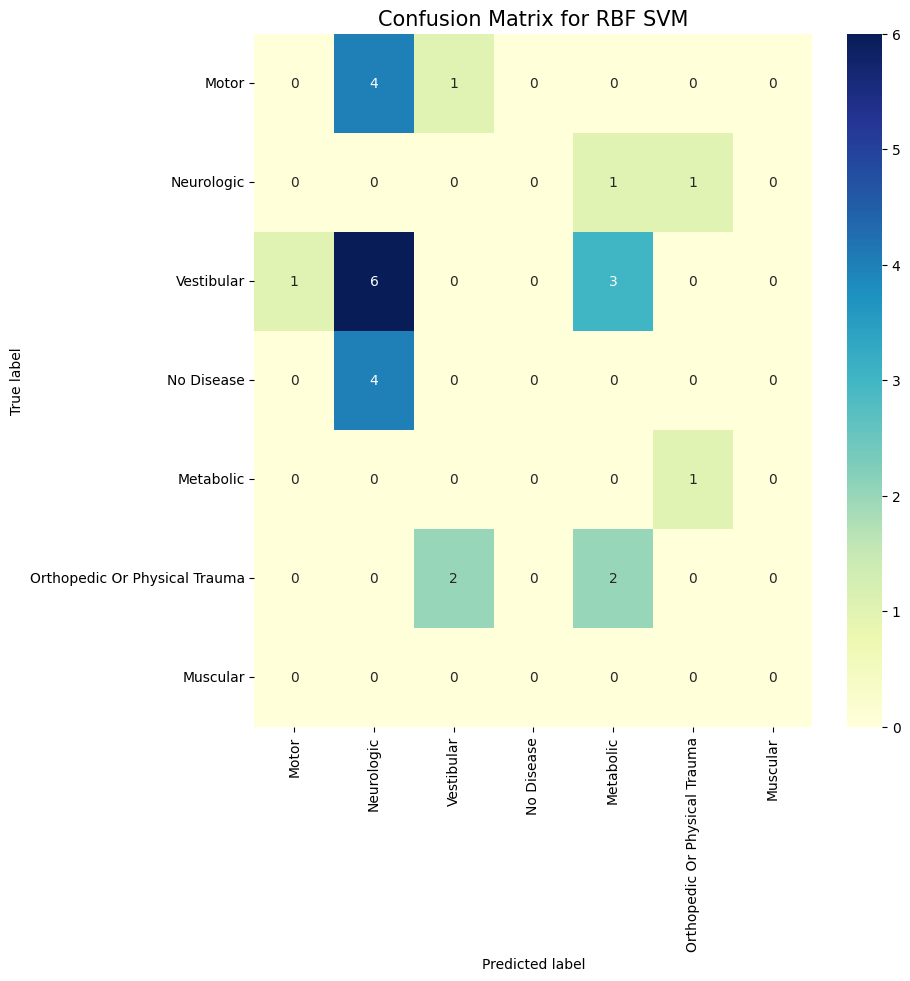


........ Score and Classification Report for Decision Tree .............

                               precision    recall  f1-score   support

                        Motor       0.00      0.00      0.00         5
                   Neurologic       0.00      0.00      0.00         2
                   Vestibular       0.40      0.20      0.27        10
                   No Disease       0.23      0.75      0.35         4
                    Metabolic       0.00      0.00      0.00         1
Orthopedic Or Physical Trauma       0.00      0.00      0.00         4
                     Muscular       0.00      0.00      0.00         0

                     accuracy                           0.19        26
                    macro avg       0.09      0.14      0.09        26
                 weighted avg       0.19      0.19      0.16        26



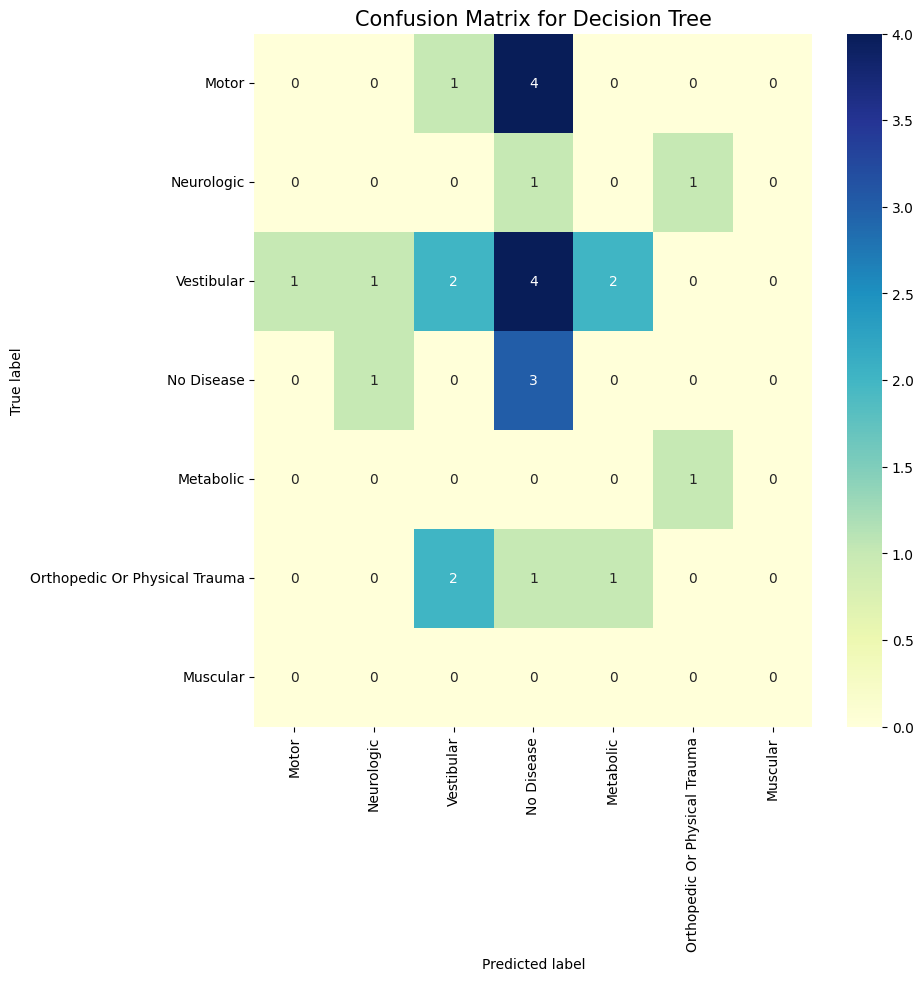


........ Score and Classification Report for Random Forest .............

                               precision    recall  f1-score   support

                        Motor       0.50      0.40      0.44         5
                   Neurologic       0.17      0.50      0.25         2
                   Vestibular       0.38      0.30      0.33        10
                   No Disease       0.67      0.50      0.57         4
                    Metabolic       0.00      0.00      0.00         1
Orthopedic Or Physical Trauma       0.00      0.00      0.00         4
                     Muscular       0.00      0.00      0.00         0

                     accuracy                           0.31        26
                    macro avg       0.24      0.24      0.23        26
                 weighted avg       0.36      0.31      0.32        26



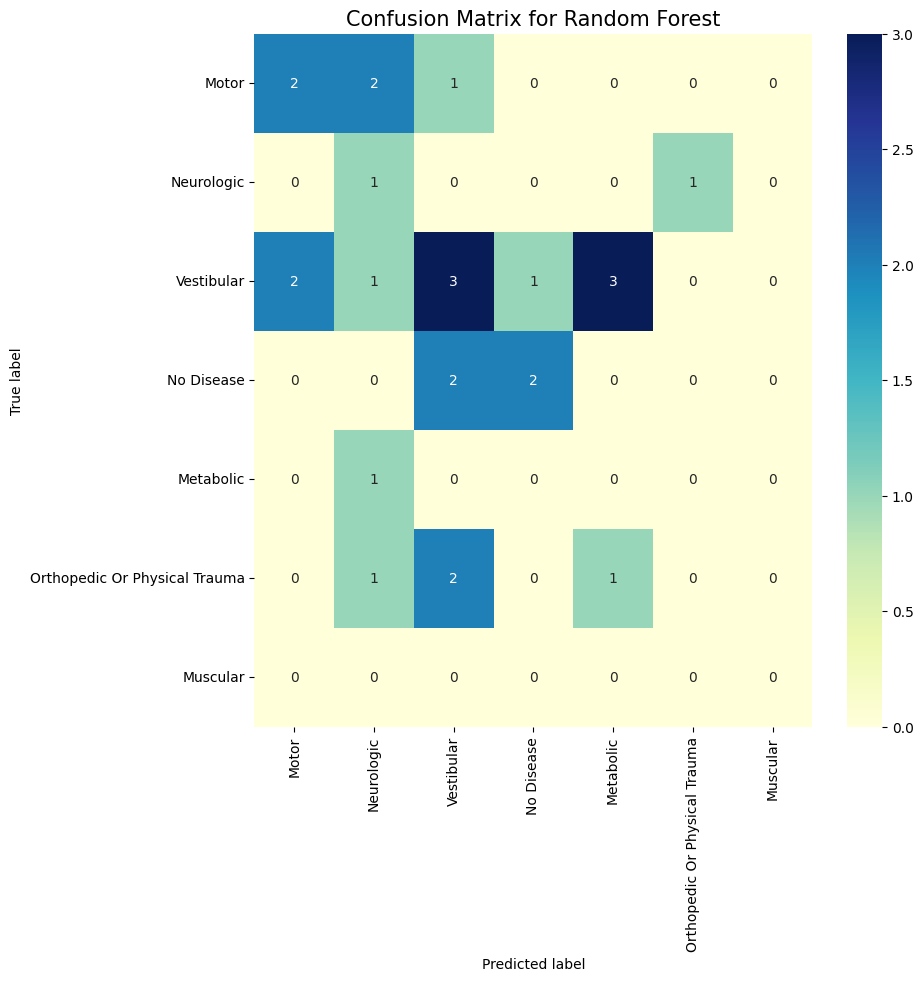


........ Score and Classification Report for Neural Net .............

                               precision    recall  f1-score   support

                        Motor       0.00      0.00      0.00         5
                   Neurologic       0.00      0.00      0.00         2
                   Vestibular       0.14      0.10      0.12        10
                   No Disease       0.13      0.50      0.21         4
                    Metabolic       0.00      0.00      0.00         1
Orthopedic Or Physical Trauma       0.00      0.00      0.00         4
                     Muscular       0.00      0.00      0.00         0

                     accuracy                           0.12        26
                    macro avg       0.04      0.09      0.05        26
                 weighted avg       0.08      0.12      0.08        26



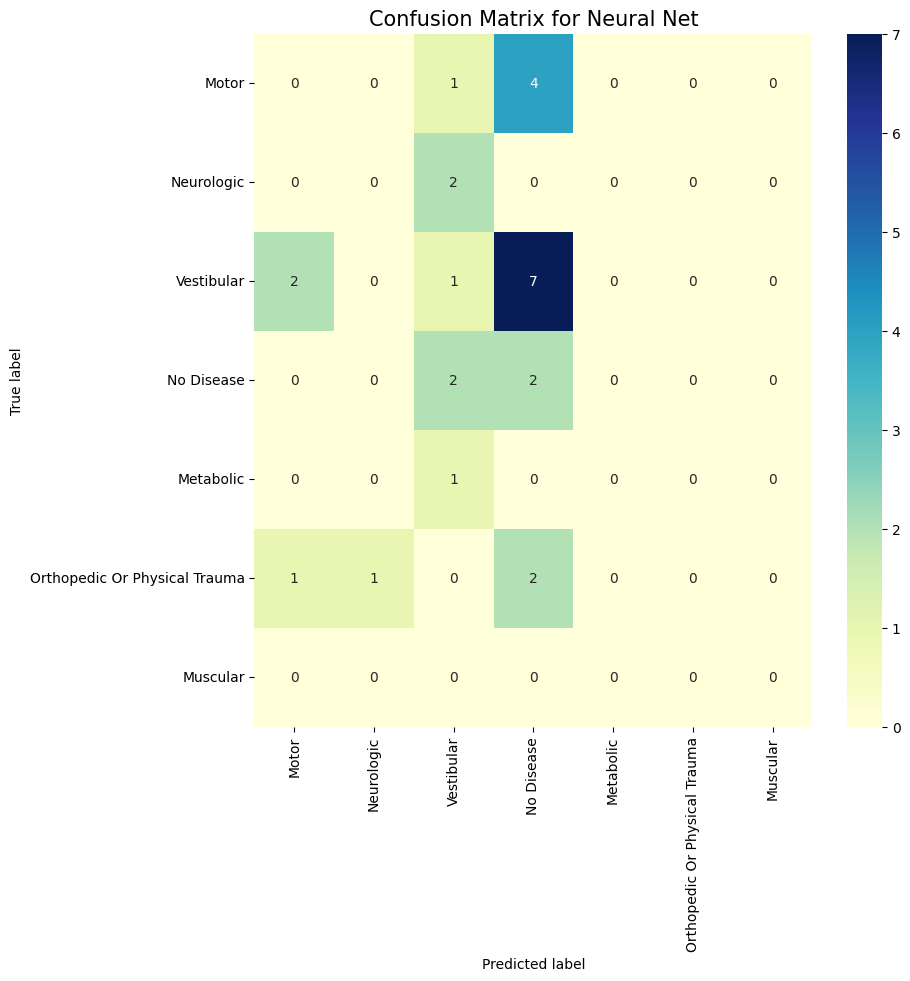


........ Score and Classification Report for AdaBoost .............

                               precision    recall  f1-score   support

                        Motor       0.38      0.60      0.46         5
                   Neurologic       0.25      0.50      0.33         2
                   Vestibular       0.36      0.50      0.42        10
                   No Disease       0.00      0.00      0.00         4
                    Metabolic       0.00      0.00      0.00         1
Orthopedic Or Physical Trauma       0.00      0.00      0.00         4
                     Muscular       0.00      0.00      0.00         0

                     accuracy                           0.35        26
                    macro avg       0.14      0.23      0.17        26
                 weighted avg       0.23      0.35      0.27        26



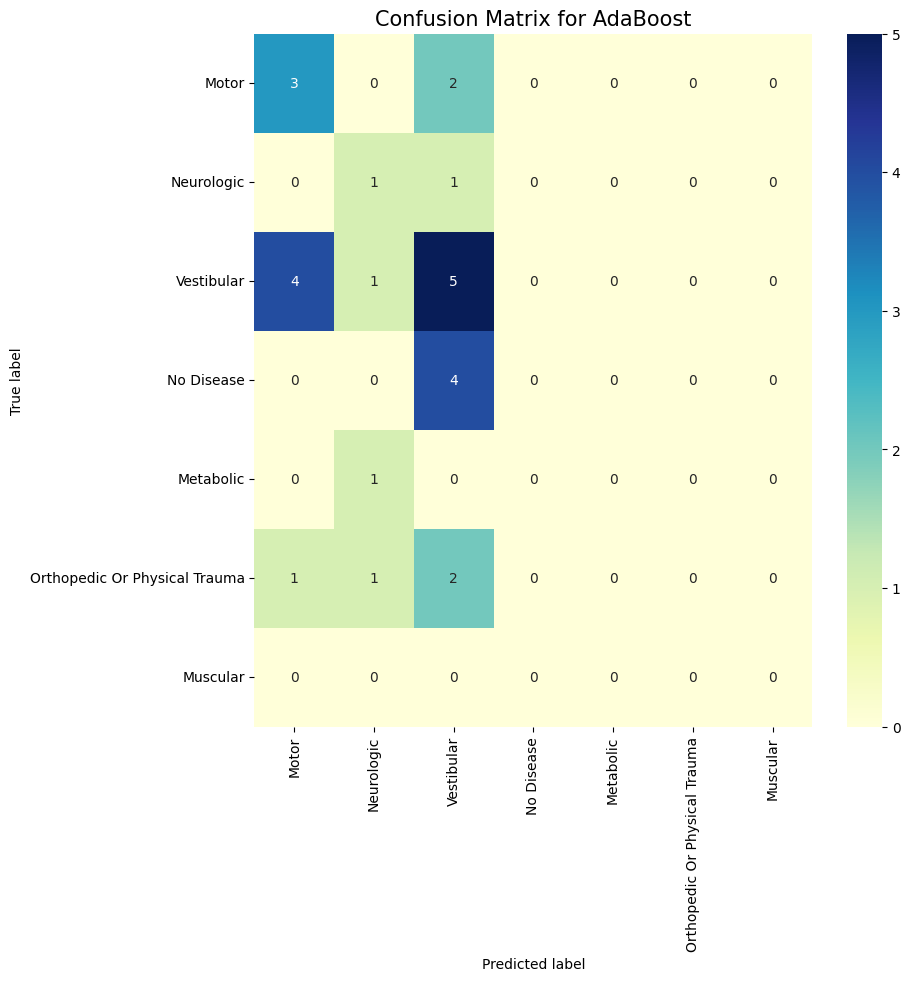


........ Score and Classification Report for Naive Bayes .............

                               precision    recall  f1-score   support

                        Motor       0.25      0.20      0.22         5
                   Neurologic       0.00      0.00      0.00         2
                   Vestibular       0.40      0.20      0.27        10
                   No Disease       0.20      0.25      0.22         4
                    Metabolic       0.00      0.00      0.00         1
Orthopedic Or Physical Trauma       1.00      0.50      0.67         4
                     Muscular       0.00      0.00      0.00         0

                     accuracy                           0.23        26
                    macro avg       0.26      0.16      0.20        26
                 weighted avg       0.39      0.23      0.28        26



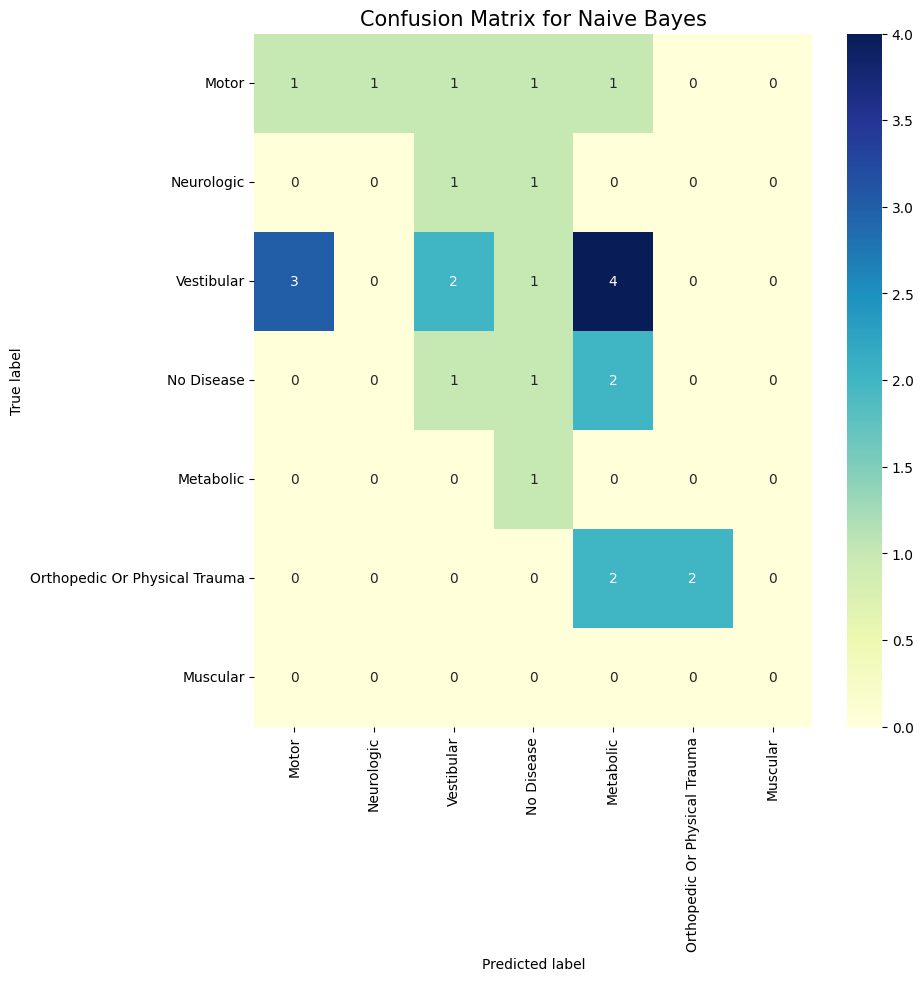

|       Classifier        |          Score          |
------------------------------------------------------
|    Nearest Neighbors    |   0.07692307692307693   |
|       Linear SVM        |   0.15384615384615385   |
|         RBF SVM         |           0.0           |
|      Decision Tree      |   0.19230769230769232   |
|      Random Forest      |   0.3076923076923077    |
|       Neural Net        |   0.11538461538461539   |
|        AdaBoost         |   0.34615384615384615   |
|       Naive Bayes       |   0.23076923076923078   |


In [15]:
# Classifiers and their names
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
]

alllabels = df_disease_expanded['DisName'].unique()

# Train and evaluate the classifiers
scores = []

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate the score
    score = clf.score(X_test, y_test)
    scores.append(score)

    print(f'\n........ Score and Classification Report for {name} .............\n')
    
    # Generate a classification report
    print(classification_report(y_test, y_pred, labels=alllabels))

    # Create a multi-label confusion matrix
    cfm = confusion_matrix(y_test, y_pred, labels=alllabels)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(9, 9))
    seaborn.heatmap(cfm, annot=True, xticklabels=alllabels, yticklabels=alllabels, cmap = 'YlGnBu')
    plt.title(f'Confusion Matrix for {name}', fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Print the classifier names and their corresponding scores
print(f"|{'Classifier':^25}|{'Score':^25}|")
print("------------------------------------------------------")
for name, score in zip(names, scores):
    print(f"|{name:^25}|{score:^25}|")

# Binary Classification By Disease

In [16]:
df_disease_boolean = pd.read_csv(results_csv, encoding='utf-8')
df_disease_boolean.drop(['Gender', 'DisCode'], inplace=True, axis=1)

# Split the 'DisName' column by ';' and create one row for each disease
df_disease_boolean['DisName'] = df_disease_boolean['DisName'].str.split(';')
df_disease_boolean_expanded = df_disease_boolean.explode('DisName')

# Clean the 'DisName' column
df_disease_expanded['DisName'] = df_disease_expanded['DisName'].str.strip()
df_disease_expanded['DisName'] = df_disease_expanded['DisName'].fillna('No Disease')

df_disease_expanded['HasDisease'] = df_disease_expanded['DisName'] != 'No Disease'

# Features (exclude 'DisName')
X = df_disease_expanded.drop(columns=['DisName'])
# Labels
y = df_disease_expanded['HasDisease']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Classifier Comparison


........ Score and Classification Report for Nearest Neighbors .............

              precision    recall  f1-score   support

        True       0.83      0.86      0.84        22
       False       0.00      0.00      0.00         4

    accuracy                           0.73        26
   macro avg       0.41      0.43      0.42        26
weighted avg       0.70      0.73      0.71        26



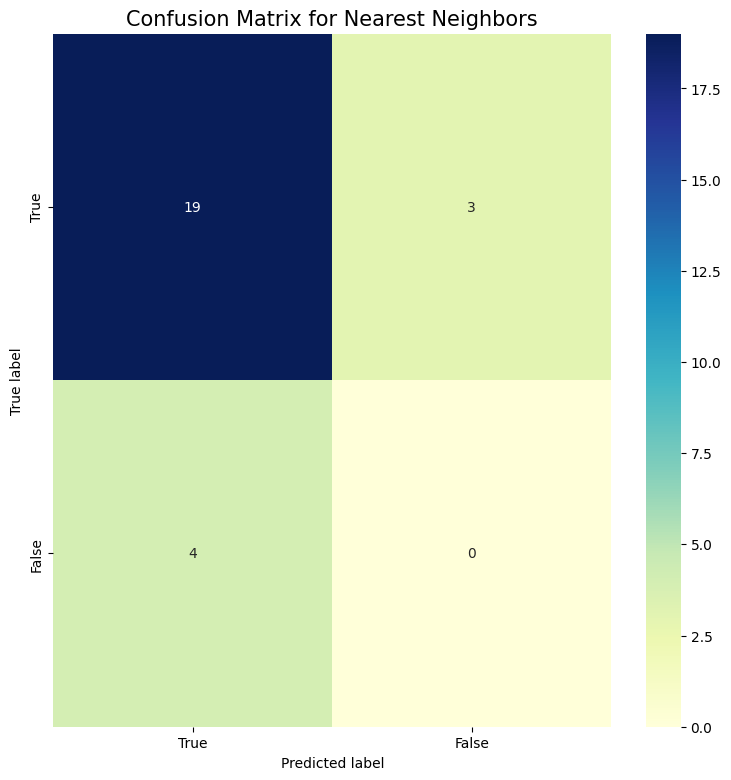


........ Score and Classification Report for Linear SVM .............

              precision    recall  f1-score   support

        True       0.84      0.95      0.89        22
       False       0.00      0.00      0.00         4

    accuracy                           0.81        26
   macro avg       0.42      0.48      0.45        26
weighted avg       0.71      0.81      0.76        26



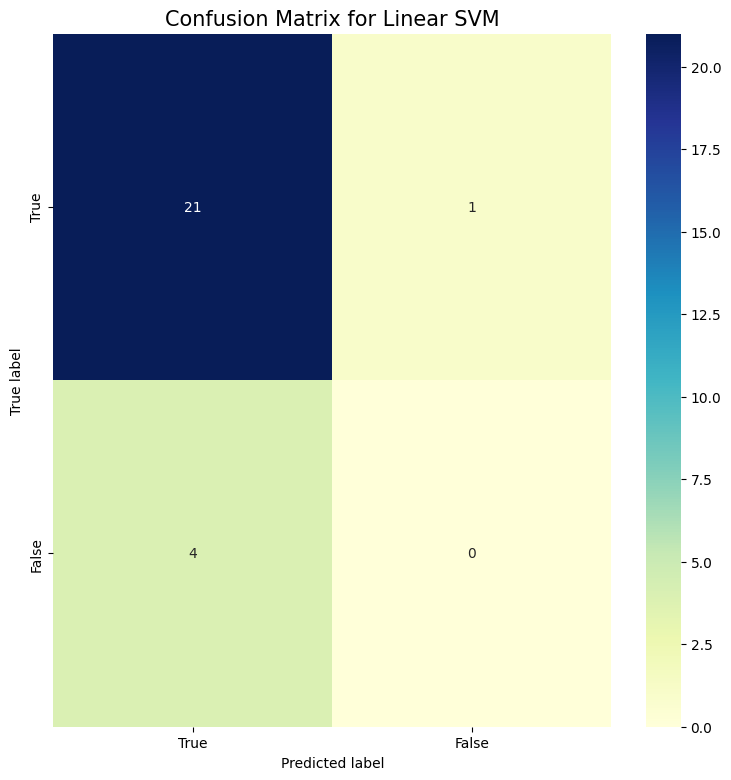


........ Score and Classification Report for RBF SVM .............

              precision    recall  f1-score   support

        True       0.85      1.00      0.92        22
       False       0.00      0.00      0.00         4

    accuracy                           0.85        26
   macro avg       0.42      0.50      0.46        26
weighted avg       0.72      0.85      0.78        26



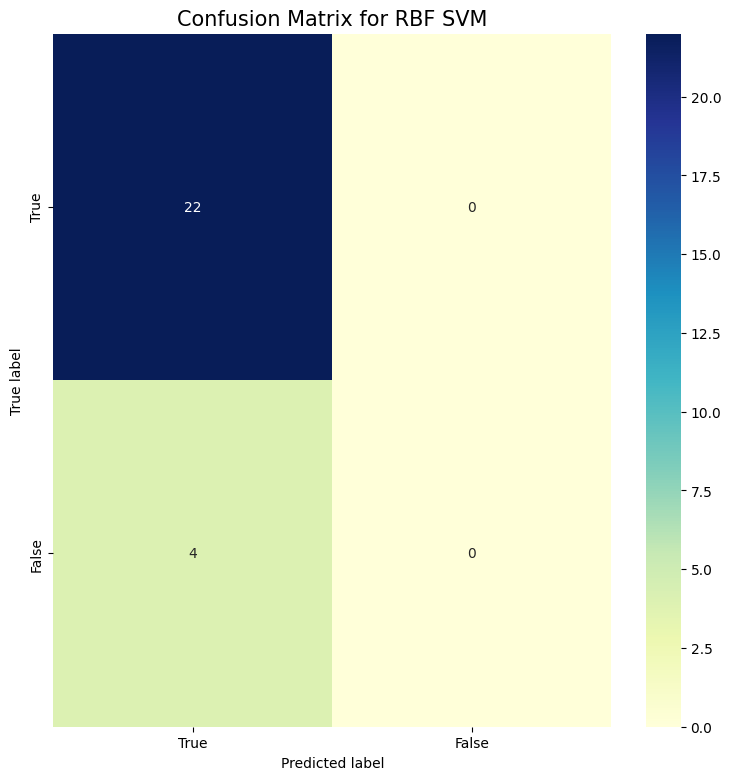


........ Score and Classification Report for Decision Tree .............

              precision    recall  f1-score   support

        True       1.00      1.00      1.00        22
       False       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



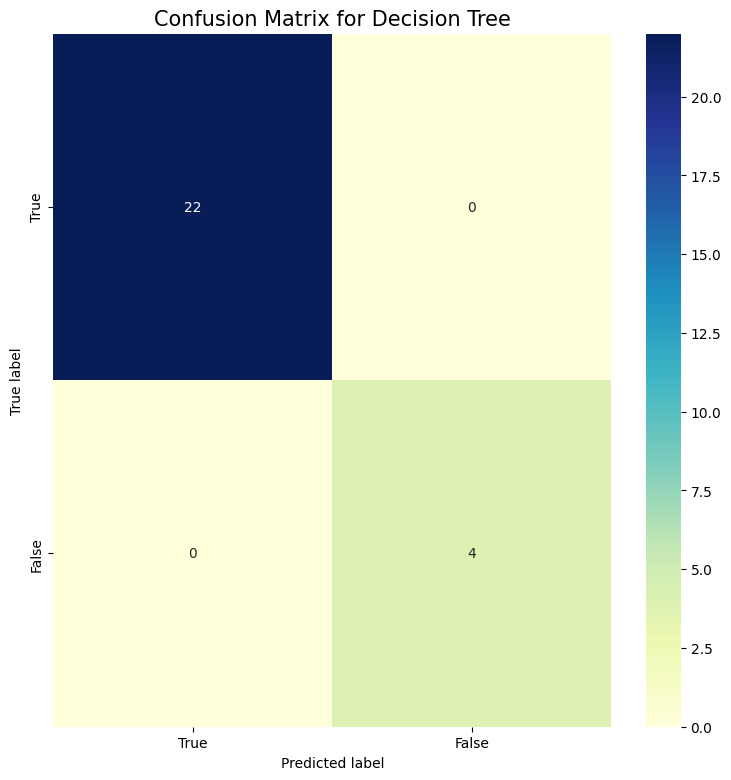


........ Score and Classification Report for Random Forest .............

              precision    recall  f1-score   support

        True       0.88      1.00      0.94        22
       False       1.00      0.25      0.40         4

    accuracy                           0.88        26
   macro avg       0.94      0.62      0.67        26
weighted avg       0.90      0.88      0.85        26



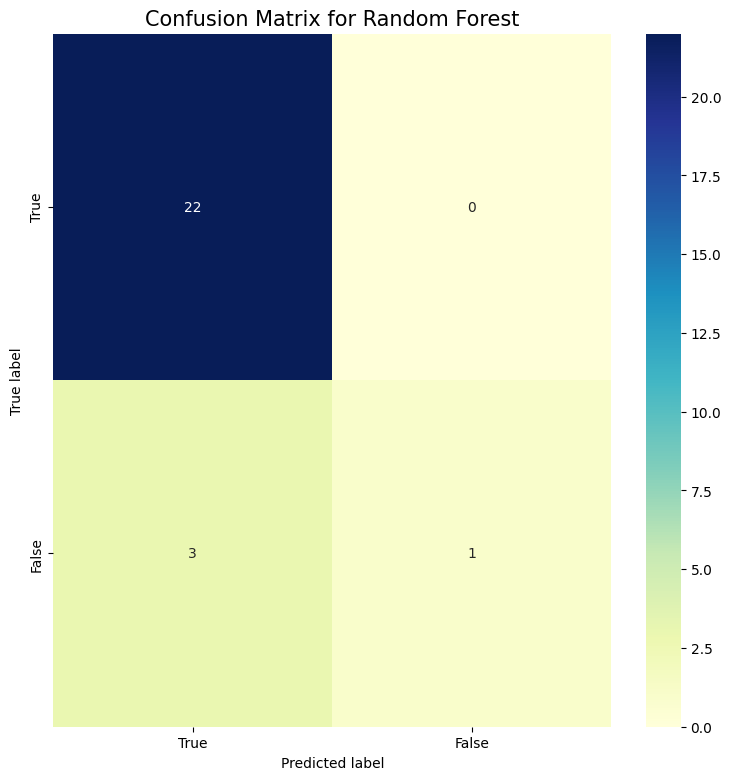


........ Score and Classification Report for Neural Net .............

              precision    recall  f1-score   support

        True       0.85      1.00      0.92        22
       False       0.00      0.00      0.00         4

    accuracy                           0.85        26
   macro avg       0.42      0.50      0.46        26
weighted avg       0.72      0.85      0.78        26



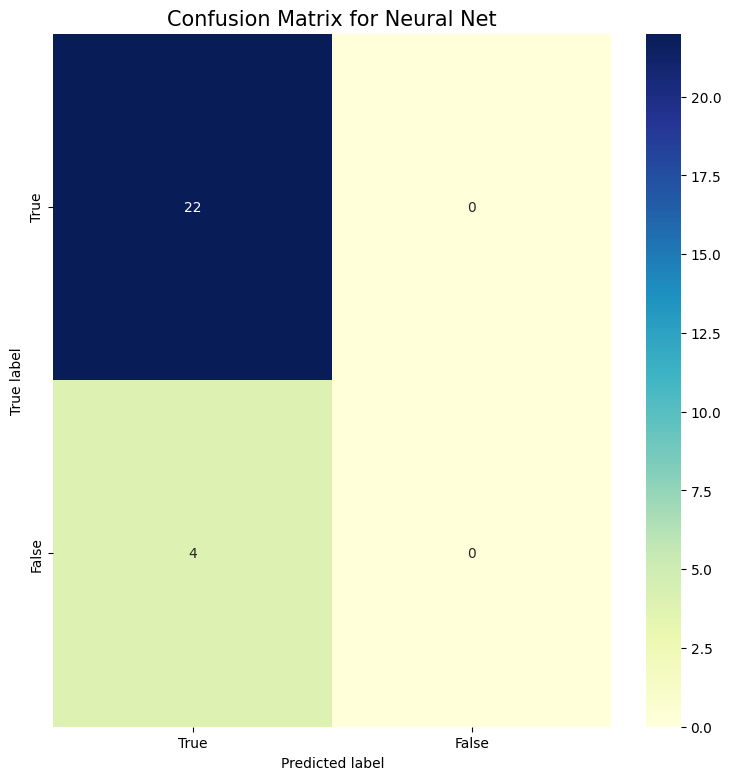


........ Score and Classification Report for AdaBoost .............

              precision    recall  f1-score   support

        True       1.00      1.00      1.00        22
       False       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



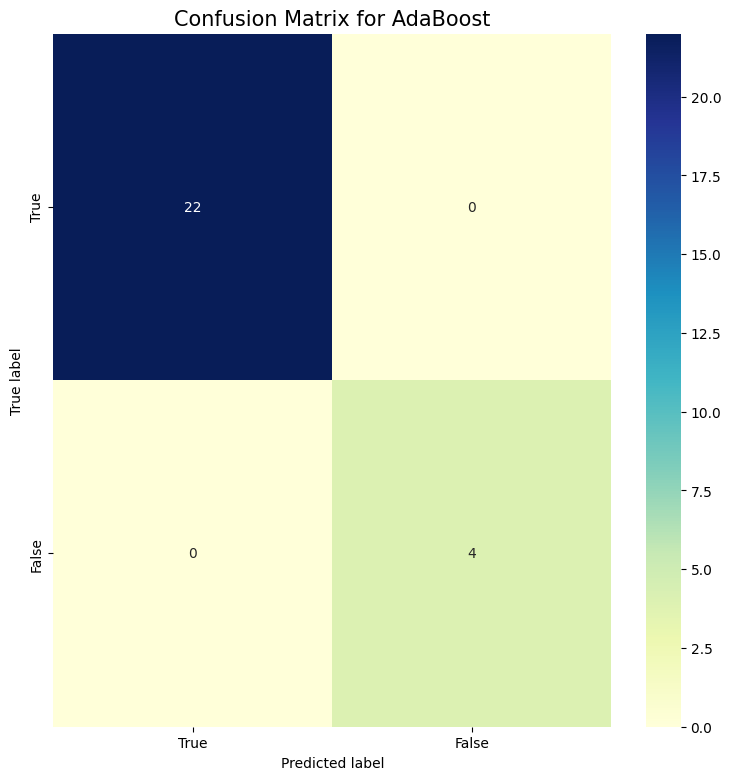


........ Score and Classification Report for Naive Bayes .............

              precision    recall  f1-score   support

        True       1.00      1.00      1.00        22
       False       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



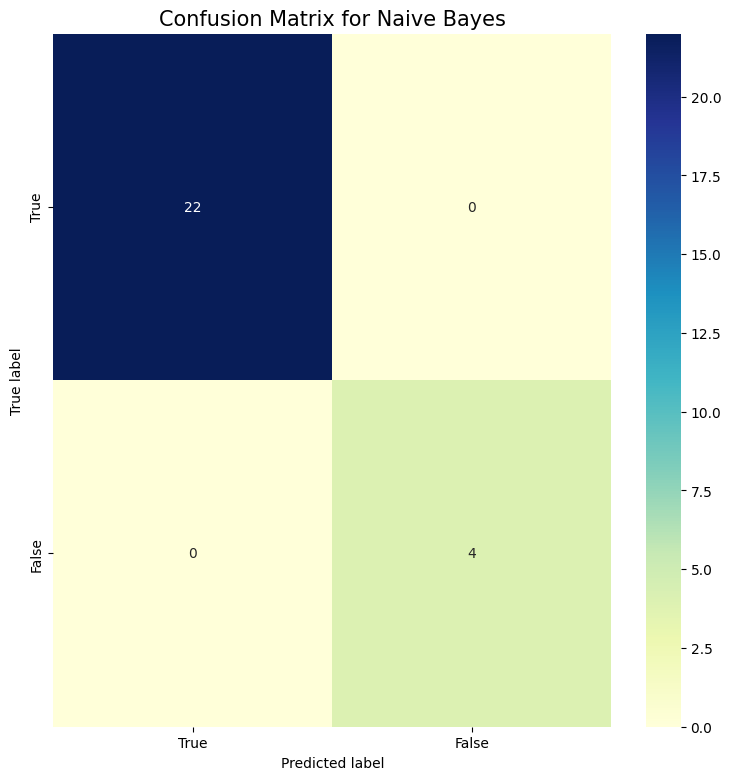

|       Classifier        |          Score          |
------------------------------------------------------
|    Nearest Neighbors    |   0.7307692307692307    |
|       Linear SVM        |   0.8076923076923077    |
|         RBF SVM         |   0.8461538461538461    |
|      Decision Tree      |           1.0           |
|      Random Forest      |   0.8846153846153846    |
|       Neural Net        |   0.8461538461538461    |
|        AdaBoost         |           1.0           |
|       Naive Bayes       |           1.0           |


In [17]:
# Classifiers and their names
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
]

alllabels = df_disease_expanded['HasDisease'].unique()

# Train and evaluate the classifiers
scores = []

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate the score
    score = clf.score(X_test, y_test)
    scores.append(score)

    print(f'\n........ Score and Classification Report for {name} .............\n')
    
    # Generate a classification report
    print(classification_report(y_test, y_pred, labels=alllabels))

    # Create a multi-label confusion matrix
    cfm = confusion_matrix(y_test, y_pred, labels=alllabels)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(9, 9))
    seaborn.heatmap(cfm, annot=True, xticklabels=alllabels, yticklabels=alllabels, cmap = 'YlGnBu')
    plt.title(f'Confusion Matrix for {name}', fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Print the classifier names and their corresponding scores
print(f"|{'Classifier':^25}|{'Score':^25}|")
print("------------------------------------------------------")
for name, score in zip(names, scores):
    print(f"|{name:^25}|{score:^25}|")

# Classification By Walking Aid Usage

In [18]:
df_walking_aid = pd.read_csv(results_csv, encoding='utf-8')
df_walking_aid.drop(['Gender', 'DisCode', 'DisName'], inplace=True, axis=1)

# Features (exclude 'DisName')
X = df_walking_aid.drop(columns=['Walking Aids'])
# Labels
y = df_walking_aid['Walking Aids']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Classifier Comparison


........ Score and Classification Report for Nearest Neighbors .............

              precision    recall  f1-score   support

       False       0.80      0.92      0.86        13
        True       0.67      0.40      0.50         5

    accuracy                           0.78        18
   macro avg       0.73      0.66      0.68        18
weighted avg       0.76      0.78      0.76        18



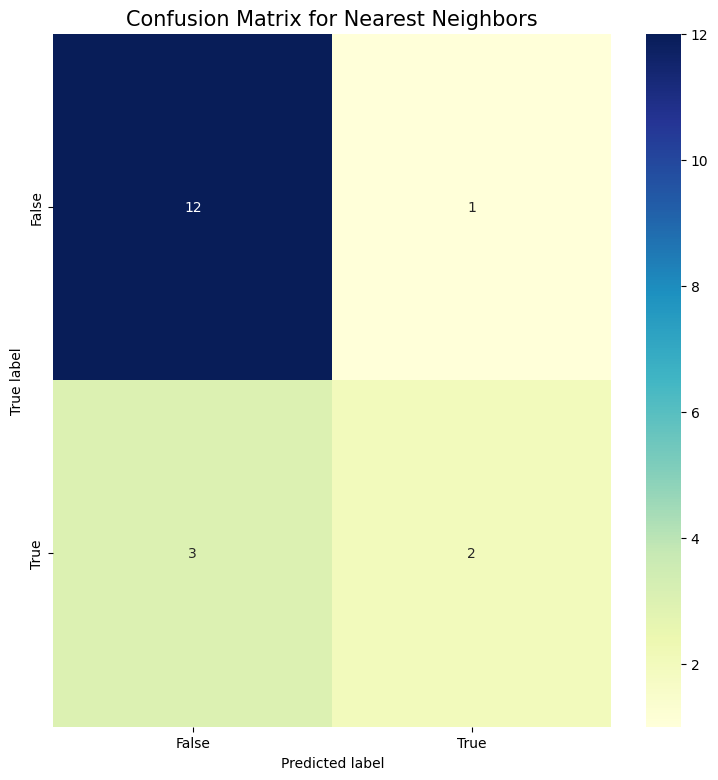


........ Score and Classification Report for Linear SVM .............

              precision    recall  f1-score   support

       False       0.93      1.00      0.96        13
        True       1.00      0.80      0.89         5

    accuracy                           0.94        18
   macro avg       0.96      0.90      0.93        18
weighted avg       0.95      0.94      0.94        18



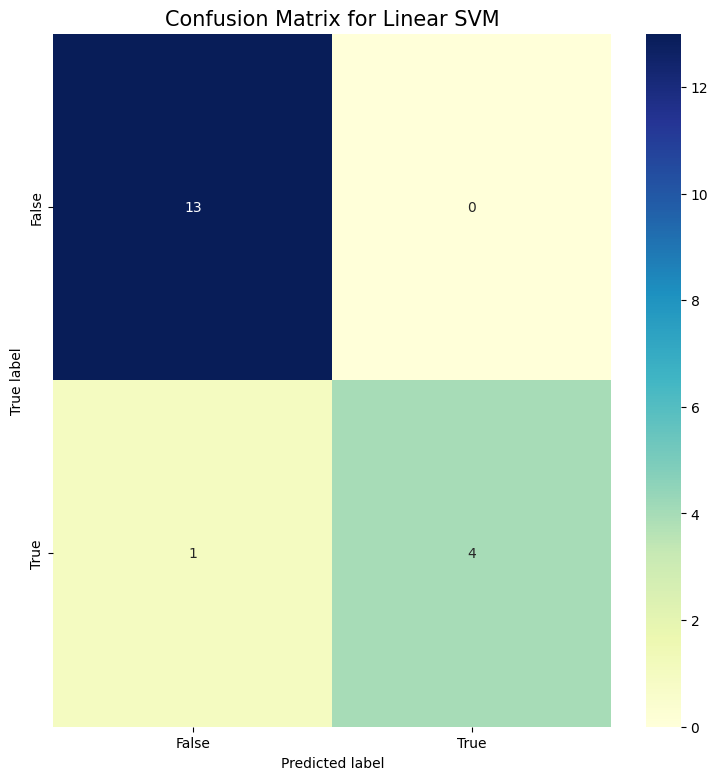


........ Score and Classification Report for RBF SVM .............

              precision    recall  f1-score   support

       False       0.72      1.00      0.84        13
        True       0.00      0.00      0.00         5

    accuracy                           0.72        18
   macro avg       0.36      0.50      0.42        18
weighted avg       0.52      0.72      0.61        18



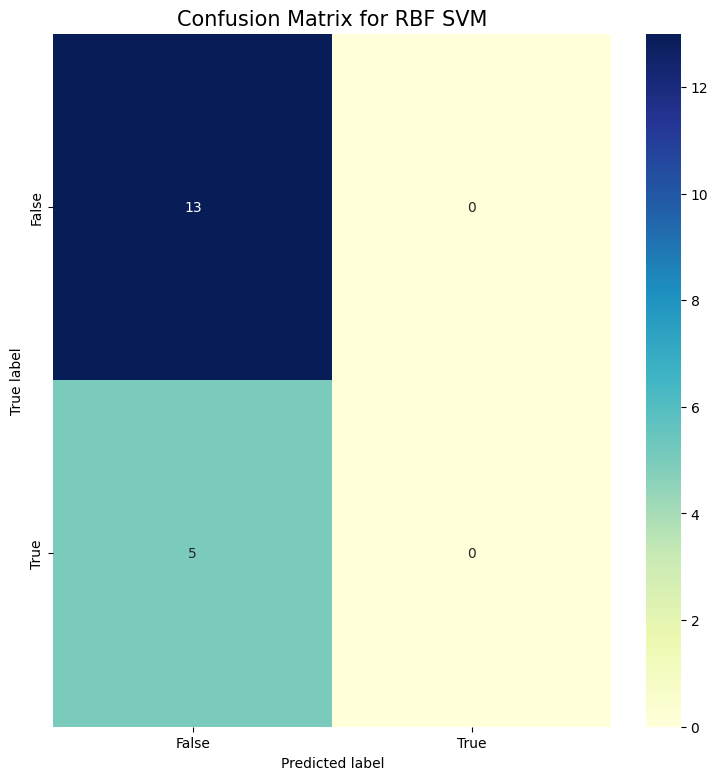


........ Score and Classification Report for Decision Tree .............

              precision    recall  f1-score   support

       False       0.93      1.00      0.96        13
        True       1.00      0.80      0.89         5

    accuracy                           0.94        18
   macro avg       0.96      0.90      0.93        18
weighted avg       0.95      0.94      0.94        18



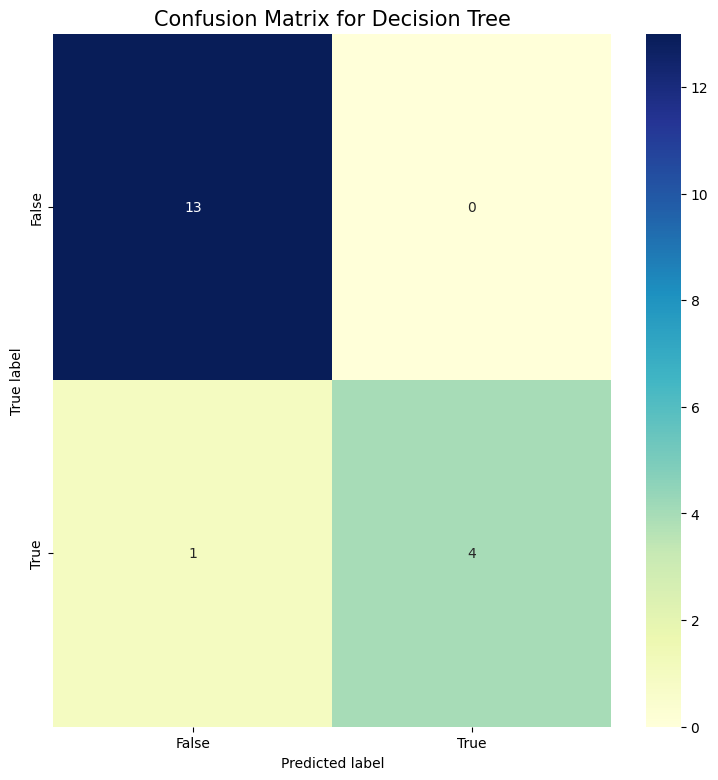


........ Score and Classification Report for Random Forest .............

              precision    recall  f1-score   support

       False       0.93      1.00      0.96        13
        True       1.00      0.80      0.89         5

    accuracy                           0.94        18
   macro avg       0.96      0.90      0.93        18
weighted avg       0.95      0.94      0.94        18



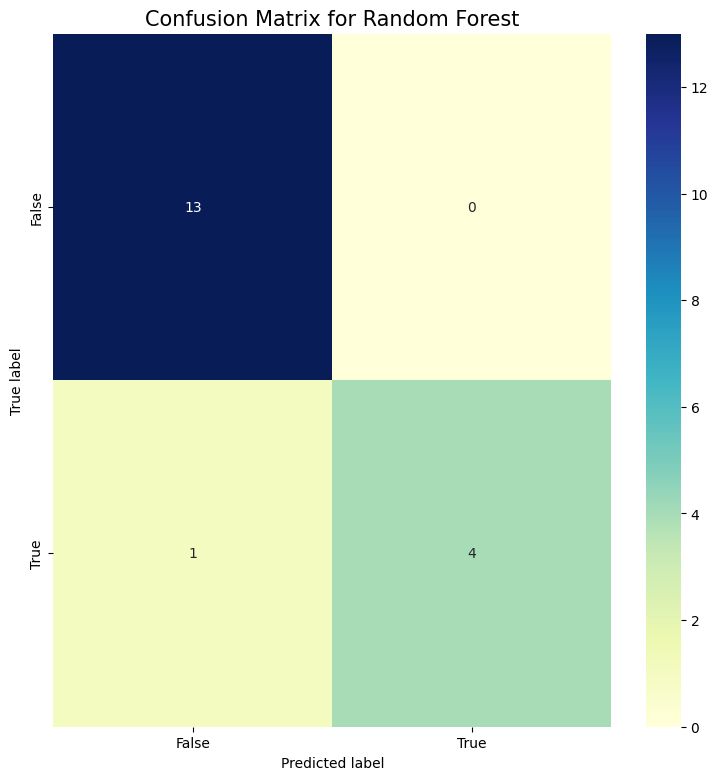


........ Score and Classification Report for Neural Net .............

              precision    recall  f1-score   support

       False       0.79      0.85      0.81        13
        True       0.50      0.40      0.44         5

    accuracy                           0.72        18
   macro avg       0.64      0.62      0.63        18
weighted avg       0.71      0.72      0.71        18



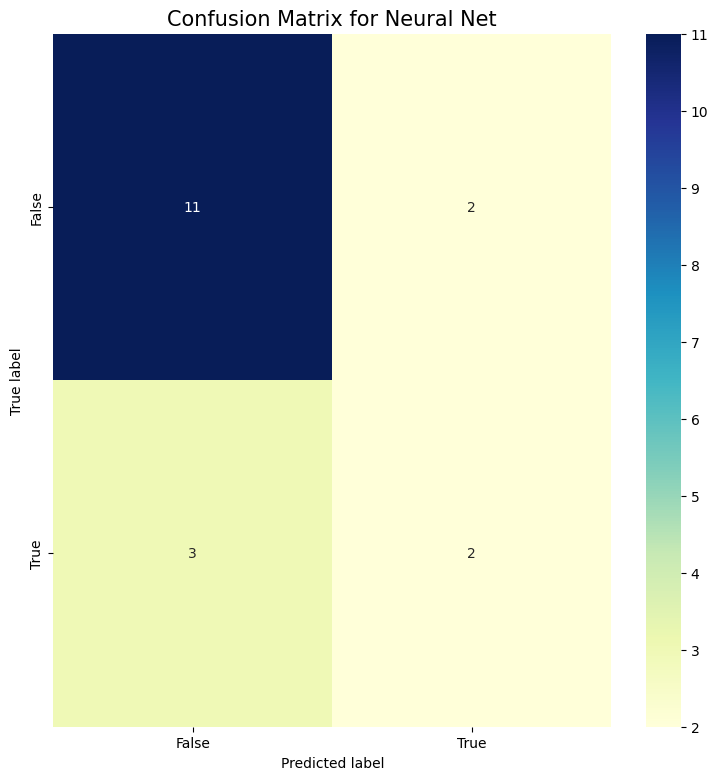


........ Score and Classification Report for AdaBoost .............

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        13
        True       1.00      1.00      1.00         5

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



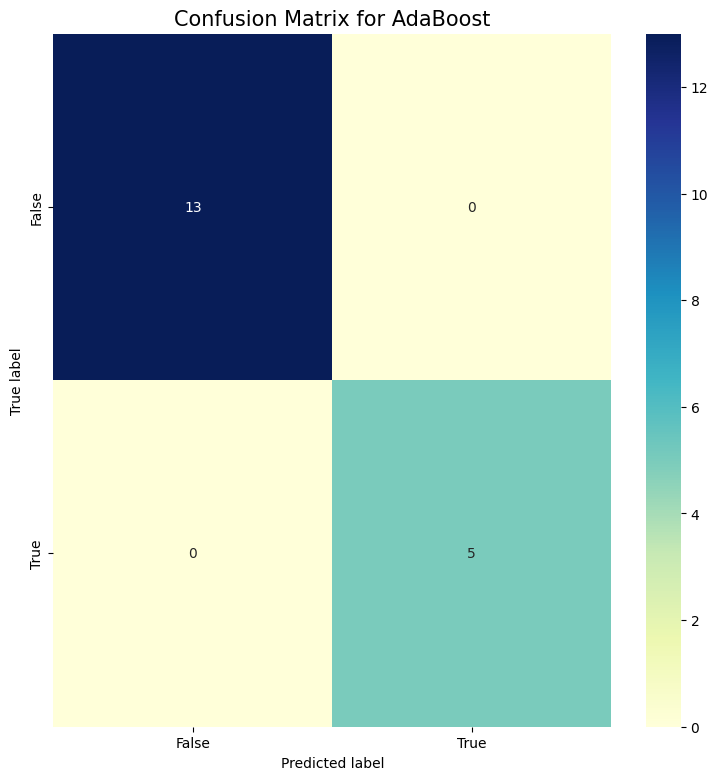


........ Score and Classification Report for Naive Bayes .............

              precision    recall  f1-score   support

       False       0.93      1.00      0.96        13
        True       1.00      0.80      0.89         5

    accuracy                           0.94        18
   macro avg       0.96      0.90      0.93        18
weighted avg       0.95      0.94      0.94        18



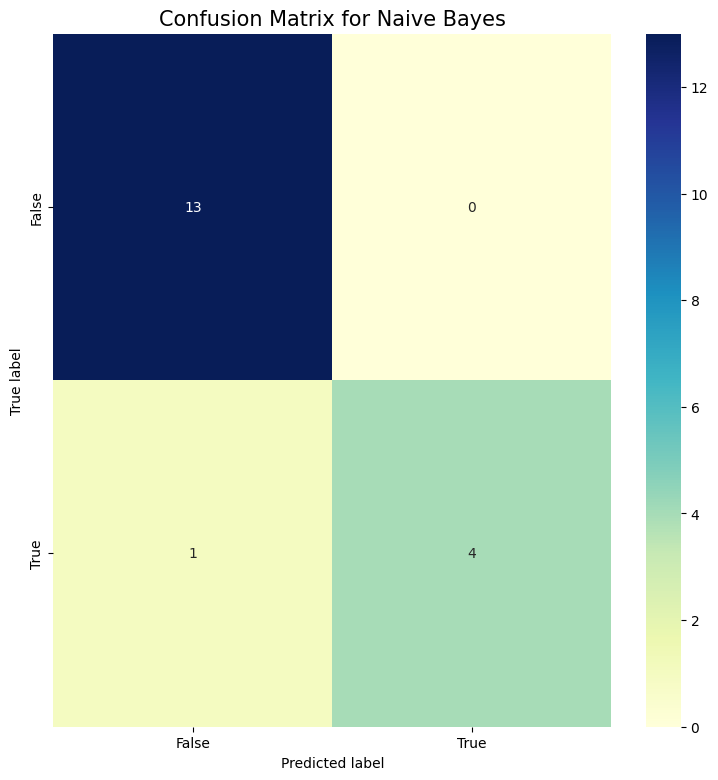

|       Classifier        |          Score          |
------------------------------------------------------
|    Nearest Neighbors    |   0.7777777777777778    |
|       Linear SVM        |   0.9444444444444444    |
|         RBF SVM         |   0.7222222222222222    |
|      Decision Tree      |   0.9444444444444444    |
|      Random Forest      |   0.9444444444444444    |
|       Neural Net        |   0.7222222222222222    |
|        AdaBoost         |           1.0           |
|       Naive Bayes       |   0.9444444444444444    |


In [19]:
# Classifiers and their names
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
]

alllabels = df_walking_aid['Walking Aids'].unique()

# Train and evaluate the classifiers
scores = []

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate the score
    score = clf.score(X_test, y_test)
    scores.append(score)

    print(f'\n........ Score and Classification Report for {name} .............\n')
    
    # Generate a classification report
    print(classification_report(y_test, y_pred, labels=alllabels))

    # Create a multi-label confusion matrix
    cfm = confusion_matrix(y_test, y_pred, labels=alllabels)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(9, 9))
    seaborn.heatmap(cfm, annot=True, xticklabels=alllabels, yticklabels=alllabels, cmap = 'YlGnBu')
    plt.title(f'Confusion Matrix for {name}', fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Print the classifier names and their corresponding scores
print(f"|{'Classifier':^25}|{'Score':^25}|")
print("------------------------------------------------------")
for name, score in zip(names, scores):
    print(f"|{name:^25}|{score:^25}|")